NOTES 
- Tokenize the narrative - we can possibly add the model from last project if we want to integrate that in 

# Libraries

In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import warnings

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import string
import nltk
nltk.download('stopwords')
import shutil

import seaborn as sns
import matplotlib.pylab as plt

from datetime import datetime, timedelta
from tqdm import tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clairephibbs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#os.chdir('C:\\Users\\halle.davis\\Downloads\\') ## Halle's work folder path
#os.chdir('/Users/halledavis/Downloads/') ## Halle's personal folder path
os.chdir('/users/clairephibbs/Desktop/Capstone') ## Claire's folder path
#os.chdir('/Users/summerpurschke/Desktop/ADS/Capstone') ## Summer's folder path

# Data Load

### Dataset Description - Violations 
1. EVENT_NO (VARCHAR2): A preassigned number used to identify each inspection, investigation, audit, survey, etc.  Use event_no to join to the Inspections table which can be joined to the Mines table with mine_id.
2. INSPECTION_BEGIN_DT (DATE): Start date of the inspection (mm/dd/yyyy).
3. INSPECTION_END_DT (DATE): Inspection close out date (mm/dd/yyyy).
4. VIOLATION_NO (VARCHAR2): Citation/order number assigned to each citation written during an inspection.  This is a unique key to the file.
5. CONTROLLER_ID (VARCHAR2): Identification number assigned by MSHA Assessments for a Legal Entity acting as a controller of an operator at the time the violation was cited. May contain null values if this record pertains to a violation issued to a contractor.
6. CONTROLLER_NAME (VARCHAR2): Name of the controller active at the time the violation was cited.  May contain null values if this record pertains to a violation issued to a contractor.
7. VIOLATOR_ID (VARCHAR2): Identification number assigned by MSHA for a Legal Entity acting as an operator at a mine at the time the violation was cited. May contain null values if this record pertains to a violation issued to a contractor.
8. VIOLATOR_NAME (VARCHAR2): Name of the operator active at the time the violation was cited.  May contain null values if this record pertains to a violation issued to a contractor.
9. VIOLATOR_TYPE_CD (VARCHAR2): Each Violator record represents an entity (Operator, Contractor, Agent or Miner) that has one or more violations at a mine.
10. MINE_ID (VARCHAR2): Mine id of the mine where the violation was issued.  Can use the mine_id to join to the Mines table.  
11. MINE_NAME (VARCHAR2): Name of the mine where the violation was issued.
12. MINE_TYPE (VARCHAR2): Mine type of the mine where the violation has been issued:  Facility, Surface or Underground.
13. COAL_METAL_IND (VARCHAR2): Identifies if the record is for a Coal or Metal/Non-Metal mine.
14. CONTRACTOR_ID (VARCHAR2): Code identifying the contractor to whom the citation or order was issued.  May contain null values if the contractor was not cited.
15. VIOLATION_ISSUE_DT (DATE): Date the citation or order was issued by the MSHA inspector.
16. VIOLATION_OCCUR_DT (DATE): Actual date of occurrence of the violation.  
17. CAL_YR (NUMBER): Calendar year during which the citation/order was issued by the MSHA inspector.
18. CAL_QTR (NUMBER): Calendar Quarter of the date the citation or order was issued by the MSHA inspector.
19. FISCAL_YR (NUMBER): Fiscal Year of the date the citation or order was issued by the MSHA inspector.  MSHA's fiscal year begins October 1 and ends September 30.
20. FISCAL_QTR (NUMBER): Fiscal Quarter of the date the citation or order was issued by the MSHA inspector.
21. VIOLATION_ISSUE_TIME (VARCHAR2): Time (24 hour) the citation or order was issued by the MSHA inspector.
22. SIG_SUB (VARCHAR2): An indicator as to whether or not the gravity is determined by the inspector to be significant and substantial.  If this is 'Y', the inspector has indicated that based upon the particular facts surrounding the violation there exists a reasonable likelihood the hazard contributed to will result in an injury or illness of a reasonably serious nature.
23. SECTION_OF_ACT (VARCHAR2): Section of the Act under which the citation/order was issued.  May contain null values.
24. PART_SECTION (VARCHAR2): Code of Federal Regulations: Part/section of Title 30 CFR violated in format PPSSSSSXXXX where (P) Part, (S) Section and (X) Suffix.  Four-digit section numbers are expanded to five within one leading zero.  May contain null values.
25. SECTION_OF_ACT_1 (VARCHAR2): Primary Section of Act which gives the MSHA Inspector the authority to take the action specified by this Issuance.   More than one type of action may be cited.
26. SECTION_OF_ACT_2 (VARCHAR2): Secondary Section of Act which gives the MSHA Inspector the authority to take the action specified by this Issuance at Metal/Non-Metal mines only.  More than one type of action may be cited.
27. CIT_ORD_SAFE (VARCHAR2): Specifies the type of Citation: Citation, Order, Safeguard, Written Notice or Notice.
28. ORIG_TERM_DUE_DT (DATE): Original date by which the cited condition was to be abated.  Original time by which the cited condition was to be abated. 
29. ORIG_TERM_DUE_TIME (VARCHAR2): Original time by which the cited condition was to be abated.   
30. LATEST_TERM_DUE_DT (DATE): Date by which the conditions cited in the citation/order are to be abated.  For Metal mines, this can be the termination due date to which the citation/order is extended.  
31. LATEST_TERM_DUE_TIME (VARCHAR2): Time by which the conditions cited on the citation/order are to be abated.  
32. TERMINATION_DT (DATE): Date on which the citation/order was terminated.  May contain null values if citation has not yet been terminated.
33. TERMINATION_TIME (VARCHAR2): Time of day (24 hour) at which the citation/order was terminated.  May contain null values if citation has not yet been terminated.
34. TERMINATION_TYPE (VARCHAR2): Code identifying the type of termination:  Issued, ReplacedByOrder or Terminated.
35. VACATE_DT (DATE): Date on which the citation/order was vacated.  May contain null values if the violation was not vacated.
36. VACATE_TIME (VARCHAR2): Time of day (24 hour) at which the citation/order was vacated.  May contain null values if the violation was not vacated.
37. INITIAL_VIOL_NO (VARCHAR2): This is the preceding citation record when there is a need to relate a citation to a previous one. For example this would apply when an order follows a citation. This relationship is needed to calculate the good faith reduction penalty points.  May contain null values.
38. REPLACED_BY_ORDER_NO (VARCHAR2): Order number which replaced the original citation.  May contain null values if situation does not apply.
39. LIKELIHOOD (VARCHAR2): This is a measure of the seriousness of the violation being cited as measured by the likelihood of the occurrence of an accident:  Highly, NoLikelihood, Occurred, Reasonably or Unlikely. May contain null values if situation does not apply.
40. INJ_ILLNESS (VARCHAR2): Value assigned to a violation for gravity of injury.  Measure of seriousness of violation being cited as measured by severity of the injury or illness to persons if accident were to occur due to the conditions of the violation: Fatal, LostDays, NoLostDays or Permanent.
41. NO_AFFECTED (NUMBER): This is a measure of the number of persons affected or potentially affected by the conditions at the Mine due to the violation.  Can be zero.
42. NEGLIGENCE (VARCHAR2): Codes representing the degree of negligence that the Inspector assigned to the violator due to the violation:  HighNegligence, LowNegligence, ModNegligence, NoNegligence or Reckless. A high degree of negligence is assigned when the operator was in a position to be aware of the condition that contributed to a dangerous situation and there were no mitigating circumstances, or if there are unique aggravating circumstances associated with the violation, such as repeated past violations of the same standard at the mine.
43. WRITTEN_NOTICE (VARCHAR2): Indicates if this citation is a result of a Miner or Agent notice of complaint to MSHA (written notice 103(g)):  ('Y'  or 'N').  May contain null values.
44. ENFORCEMENT_AREA (VARCHAR2): Specifies the enforcement areas affected by the violating condition or practice constitute a health hazard, safety hazard, both or other type of hazard. May contain null values.
45. SPECIAL_ASSESS (VARCHAR2): Specifies whether this citation has been designated for Special Assessment based on Special Assessment Review (Y or N).
46. PRIMARY_OR_MILL (VARCHAR2): A code indicating if the Violation was observed in the Primary Mine location or in an associated Mill (Metal/Non-Metal only). May contain null values.
47. RIGHT_TO_CONF_DT (DATE): Date the operator was advised of his right to a conference (Metal/Non-Metal only).  May contain null values.
48. ASMT_GENERATED_IND (VARCHAR2): If the violator is an Operator or Contractor, the indicator is 'N'. If the violator is an Agent, the indicator is 'Y'. If the violator is a Miner, the indicator can be 'Y' or 'N'. If none of the above, the indicator is '?'.
49. FINAL_ORDER_ISSUE_DT (DATE): Date that this assessment becomes a Final Order.  This date is set when the Certified Return Receipt date (CRR) is set.  Note that this can be a projected future date that is set as soon as the CRR is entered.  
50. PROPOSED_PENALTY (NUMBER): The original dollar value of the proposed penalty prior to any modifications such as those possibly resulting from a decision on a contested case.
51. AMOUNT_DUE (NUMBER): The current dollar value of the proposed assessment, reflecting any modifications that have been made since it was originally assessed.
52. AMOUNT_PAID (NUMBER): The total dollar value of all payments applied to this proposed assessment to date.
53. BILL_PRINT_DT (DATE): Date the bill was printed.  This date always represents the first time the bill was printed.
54. LAST_ACTION_CD (VARCHAR2): Last action taken against this violation such as 1stDemandPrinted, BillingReady, ApprovedforTreasury and Proposed.  
55. LAST_ACTION_DT (DATE): Date the last action taken against this violation.
56. DOCKET_NO (VARCHAR2): The Docket Number assigned by the Court to this group of Assessments being contested.
57. DOCKET_STATUS_CD (VARCHAR2): Denotes the current status of this docket:  Approved (approved by the court) or Proposed (not yet been approved by the court).
58. CONTESTED_IND (VARCHAR2): Indicates if this violation has been assessed and is being contested (Y or N).
59. CONTESTED_DT (DATE): Date of the most recent docket status for this violation.
60. VIOLATOR_VIOLATION_CNT (NUMBER): Total number of assessed violations for this violator at this time during the violation history period. Used in penalty calculation.  Applies to an Operator or a Contractor.
61. VIOLATOR_INSPECTION_DAY_CNT (NUMBER): Total number of inspections for this Operator at a mine during the violation history period. Used in penalty calculation. Does not apply to Contractor.

### Dataset Description - Accidents

TABLE_NAME|COLUMN_NAME|DATA_TYPE|DATA_LENGTH|FIELD_DESCRIPTION

1. MINE_ID|VARCHAR2|7|Identification number assigned to the mine by MSHA.  It is the mine identification number of the mine where the accident/injury/illness occurred.  Use mine_id to join to the Mines and Inspections tables.  Use mine_id and cal_yr to join to mine_id and cal_yr in Qrtly and Annual Employ Emprod tables.
2. CONTROLLER_ID|VARCHAR2|7|Identification number assigned by MSHA Assessments for a Legal Entity acting as a controller of an operator at the time of the accident.   May contain null values.   
3. CONTROLLER_NAME|VARCHAR2|100|Name of the controller active at the time of the accident.  May contain null values. 
4. OPERATOR_ID|VARCHAR2|7|Identification number assigned by MSHA for a Legal Entity acting as an operator at a mine at the time of the accident.  May contain null values.
5. OPERATOR_NAME|VARCHAR2|60|Name of the operator active at the time of the accident.  May contain null values.
6. CONTRACTOR_ID|VARCHAR2|10|Identification number assigned by MSHA for companies working as contractors at a mine.  It is the contractor id of the contractor or contractor employee involved in the accident/injury.  May contain null values if the accident did not involve a contractor.
7. DOCUMENT_NO|VARCHAR2|12|Document number assigned to the accident/injury form.  The first number designates the type of document:  (1) employment, (2) injury and (3) closing document.  The next seven are the Julian date (YYYYDDD).  The last four characters are a sequential number.
8. SUBUNIT_CD|VARCHAR2|2|Code that identifies the location within a mine where the accident/injury/illness occurred.
9. SUBUNIT|VARCHAR2|32|Description of the subunit code referring to the location within a mine where the accident/injury/illness occurred: (01) Underground; (02) Surface at underground; (03) Strip, quarry, open pit; (04) Auger; (05) Culm bank/refuse pile; (06) Dredge; (12) Other mining; (17) Independent shops or yards; (30) Mill operation/preparation plant; (99) Office workers at mine site. 
10. ACCIDENT_DT|DATE|10|Date the accident/injury/illness occurred (mm/dd/yyyy).
11. CAL_YR|NUMBER|4|Calendar Year in which the accident/injury/illness occurred.  It is based on the accident date.
12. CAL_QTR|NUMBER|1|Calendar Quarter in which the accident/injury/illness occurred.  It is based on the accident date.
13. FISCAL_YR|NUMBER|4|Fiscal Year in which the accident/injury/illness occurred.  MSHA's fiscal year begins October 1 and ends September 30.  It is based on the accident date.
14. FISCAL_QTR|NUMBER|1|Fiscal Quarter in which the accident/injury/illness occurred.  It is based on the accident date.
15. ACCIDENT_TIME|NUMBER|4|Time the accident/injury/illness occurred (24-hour clock).
16. DEGREE_INJURY_CD|VARCHAR2|2|Code identifying the degree of injury/illness to the individual.
17. DEGREE_INJURY|VARCHAR2|30|Description of the degree of injury/illness to the individual: (00) Accident only; (01) Fatality; (02) Permanent total or permanent partial disability; (03) Days away from work only; (04) Days away from work and restricted activity; (05) Days restricted activity only; (06) No days away from work, no restrictions; (07) Occupational illness not degree 1-6; (08) Injuries due to natural causes; (09) Injuries involving non-employees; (10) All other cases (incl. 1st aid); (?) No value found.
18. FIPS_STATE_CD|VARCHAR2|2|Federal Information Processing Standard (FIPS) state code.  It refers to the state in which accident/injury/illness occurred.
19. UG_LOCATION_CD|VARCHAR2|2|Code identifying the underground location where the accident/injury/illness occurred.
20. UG_LOCATION|VARCHAR2|28|Description of the underground location code where the accident/injury/illness occurred: (01) Vertical shaft; (02) Slope/inclined shaft; (03) Face; (04) Intersection; (05) Underground shop/office; (06) Last open crosscut; (07) Inby permanent support; (08) Haulageway; (09) Other entry (not haulageway); (98) Other; (99) Not Marked; (?) No value found.
21. UG_MINING_METHOD_CD|VARCHAR2|2|Description of the underground mining method code where the accident/injury/illness occurred.
22. UG_MINING_METHOD|VARCHAR2|20|Description of the underground mining method code where the accident/injury/illness occurred: (01) Longwall; (02) Shortwall; (03) Conventional Stoping; (05) Continuous Miner; (06) Hand; (07) Caving; (08) Other; (?) No Value Found.
23. MINING_EQUIP_CD|VARCHAR2|6|Code to designate the type of equipment involved in the incident.  May be '?' if invalid code.
24. MINING_EQUIP|VARCHAR2|56|Description for the type of mining equipment involved in the accident.  May be 'No Value Found' if invalid mining equipment code.
25. EQUIP_MFR_CD|VARCHAR2|4|Codes that identify the manufacturer of equipment involved in the incident.  May be '?' if invalid code.
26. EQUIP_MFR_NAME|VARCHAR2|50|Mining machine manufacturer of a machine involved in an accident.  May be 'No Value Found' if invalid equipment manufacture code.
27. EQUIP_MODEL_NO|VARCHAR2|25|Model number that identifies the equipment involved in the incident.
28. SHIFT_BEGIN_TIME|NUMBER|4|Time the shift started (24-hour clock) during which the incident occurred.
29. CLASSIFICATION_CD|VARCHAR2|2|Accident or injury classification code.  The accident classification identifies the circumstances which contributed most directly to the resulting accident.
30. CLASSIFICATION|VARCHAR2|37|Description of the accident classification code that identifies the circumstances which contributed most directly to the resulting accident.
31. ACCIDENT_TYPE_CD|VARCHAR2|2|The accident type code identifies the event which directly resulted in the reported injury/accident.
32. ACCIDENT_TYPE|VARCHAR2|30|Description of the accident type code.
33. NO_INJURIES|NUMBER|4|Number of reportable injuries or illnesses resulting from the accident.  Zero is a valid number if no employees were injured in the accident or if the injury was not reportable.
34. TOT_EXPER|NUMBER|4,2|Total mining experience of the person affected calculated in decimal years.  The calculation uses both the years and months experience.  May contain null values. 
35. MINE_EXPER|NUMBER|4,2|Total experience at a specific mine of the person affected calculated in decimal years.  The calculation uses both the years and months experience at the mine.  May contain null values.
36. JOB_EXPER|NUMBER|4,2|Experience in the job title of the person affected calculated in decimal year.  The calculation uses both the years and months experience.  May contain null values.
37. OCCUPATION_CD|VARCHAR2|3|Three-digit occupation code of the accident victim's regular job title.
38. OCCUPATION|VARCHAR2|40|Description of the occupation code.
39. ACTIVITY_CD|VARCHAR2|3|Code for the specific activity the accident victim was performing at the time of the incident.  May be '?' if invalid code.
40. ACTIVITY|VARCHAR2|33|Description of the activity code.  May be 'No Value Found' if activity code is invalid.
41. INJURY_SOURCE_CD|VARCHAR2|3|Code identifying the source of the injury or illness.  The source of injury identifies the object, substances, exposure or bodily motion which directly produced or inflicted the injury.  May be '?' if invalid code.
42. INJURY_SOURCE|VARCHAR2|25|Description of the injury source code.  May have a description of 'No Value Found' if invalid injury source code.
43. NATURE_INJURY_CD|VARCHAR2|3|The nature of injury identifies the injury in terms of its principle physical characteristics.  May be '?' if invalid code.
44. NATURE_INJURY|VARCHAR2|25|Description of the nature of the victim's injury.  May have a description of  'No Value Found' if invalid nature of injury code.
45. INJ_BODY_PART_CD|VARCHAR2|3|Code identifying the part of the body affected by an injury.  May be '?' if invalid code.
46. INJ_BODY_PART|VARCHAR2|39|Description of the part of the body affected by an injury.  May have a description of 'No Value Found' if invalid injured body part code.
47. SCHEDULE_CHARGE|NUMBER|4|Charge in days lost for any permanent injury/illness.  Example:  6000 days for a death, 2400 days for the loss of a foot at the ankle.  May contain data (null values) if situation does not apply.
48. DAYS_RESTRICT|NUMBER|4|Number of days of restricted work activity due to the injury/illness.  May contain null values if situation does not apply.
49. DAYS_LOST|NUMBER|3|Actual days lost from work due to the injury/illness.  May not contain null values if situation does not apply.
50. TRANS_TERM|VARCHAR2|1|Indicates if the injured/ill employee was permanently transferred or terminated (Y or N).  May contain null values if situation does not apply.
51. RETURN_TO_WORK_DT|DATE|10|Date the injured/ill employee returned to work (mm/dd/yyyy).  May contain null values if situation does not apply.
52. IMMED_NOTIFY_CD|VARCHAR2|2|Code describing if the accident is one of the 12 types immediately reportable to MSHA.
53. IMMED_NOTIFY|VARCHAR2|20|Description of the Immediate Notification code:  (01) Death; (02) Serious injury; (03) Entrapment; (04) Inundation; (05) Gas of dust ignition; (06) Mine fire; (07) Explosives; (08) Roof fall; (09) Outburst; (10) Impounding dam; (11) Hoisting; (12) Offsite; (13) Not marked; (?) No value found. 
54. INVEST_BEGIN_DT|DATE|10|Date the MSHA accident investigation started (mm/dd/yyyy).
55. NARRATIVE|VARCHAR2|384|Narrative description of the accident/injury/illness.
56. CLOSED_DOC_NO|VARCHAR2|12|Document number assigned to the Returned to Duty form. The first character is designated as a '3' for the closing document.  The next seven are the Julian date (YYYYDDD).  The last four characters are a sequential number.  May contain null values.
57. COAL_METAL_IND|VARCHAR2|1|Identifies if the accident occurred at a Coal or Metal/Non-Metal mine.

Note for summer 
- if it's showing that the file is not found try to redownload the data from the website. It goes to icloud after a bit for some reason

In [3]:
accidents = pd.read_csv('Accidents.txt', sep= '|', encoding = 'latin-1')
violations = pd.read_csv('Violations.txt', sep= '|', encoding = 'latin-1')

# inspections = pd.read_csv('Inspections.txt', sep= '|', encoding = 'latin-1')
# mines = pd.read_csv('Mines.txt', sep= '|', encoding = 'latin-1')

/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4217344869.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv('Accidents.txt', sep= '|', encoding = 'latin-1')
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4217344869.py:2: DtypeWarning: Columns (25,34,36,37,43,45,46,55,56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  violations = pd.read_csv('Violations.txt', sep= '|', encoding = 'latin-1')


# Exploratory Data Analysis (EDA)

## Violations Dataset

### Viewing the Violations Data

In [4]:
# Viewing first few rows of violations df
violations.head() 

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,DOCKET_NO,DOCKET_STATUS_CD,CONTESTED_IND,CONTESTED_DT,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,01/04/2000,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
1,711256,01/04/2000,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
2,711256,01/04/2000,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
3,711256,01/04/2000,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,196.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
4,711256,01/04/2000,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0


In [5]:
# Printing the shape/dimensions of violations df
print(violations.shape)

(2812757, 61)


INSIGHT: We have more than 2 million rows (almost 3 million) and 61 columns.

In [6]:
# Viewing descriptive statistics of numerical columns in violations df
violations.describe()

,EVENT_NO,VIOLATION_NO,MINE_ID,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,VIOLATION_ISSUE_TIME,ORIG_TERM_DUE_TIME,LATEST_TERM_DUE_TIME,TERMINATION_TIME,VACATE_TIME,NO_AFFECTED,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
count,2.812757e+06,2.812757e+06,2.812757e+06,2.812757e+06,2.812757e+06,2.812757e+06,2.812757e+06,2.812757e+06,2.134975e+06,2.718445e+06,2.794131e+06,70.000000,2.812757e+06,2.749690e+06,2.749690e+06,2.749690e+06,2.749690e+06,2.749690e+06
mean,4.463453e+06,7.854388e+06,2.698194e+06,2.010446e+03,2.441750e+00,2.010670e+03,2.546500e+00,1.123196e+03,1.217979e+03,1.200539e+03,1.152241e+03,22.157143,1.481975e+00,5.890649e+02,4.720882e+02,4.070087e+02,1.231055e+02,1.673952e+02
std,2.214542e+06,1.184529e+06,1.552248e+06,6.281720e+00,1.103279e+00,6.286221e+00,1.098501e+00,3.106758e+02,3.742648e+02,3.763959e+02,3.180579e+02,185.379957,6.266838e+00,3.111682e+03,2.254934e+03,1.887374e+03,2.281404e+02,3.010801e+02
min,3.206180e+05,7.299270e+05,1.000030e+05,1.994000e+03,1.000000e+00,1.994000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.041855e+06,7.044468e+06,1.509571e+06,2.006000e+03,1.000000e+00,2.006000e+03,2.000000e+00,9.300000e+02,9.000000e+02,9.000000e+02,9.350000e+02,0.000000,1.000000e+00,1.000000e+02,1.000000e+02,6.000000e+01,1.000000e+00,1.000000e+00
50%,4.413849e+06,8.042356e+06,2.602246e+06,2.010000e+03,2.000000e+00,2.010000e+03,3.000000e+00,1.100000e+03,1.200000e+03,1.200000e+03,1.125000e+03,0.000000,1.000000e+00,1.230000e+02,1.230000e+02,1.170000e+02,1.500000e+01,1.800000e+01
75%,6.542202e+06,8.817967e+06,4.405166e+06,2.015000e+03,3.000000e+00,2.015000e+03,4.000000e+00,1.302000e+03,1.500000e+03,1.500000e+03,1.335000e+03,0.000000,1.000000e+00,3.080000e+02,2.860000e+02,2.630000e+02,1.350000e+02,1.780000e+02
max,8.890948e+06,9.988780e+06,5.500013e+06,2.023000e+03,4.000000e+00,2.023000e+03,4.000000e+00,2.359000e+03,2.359000e+03,2.359000e+03,2.359000e+03,1551.000000,9.990000e+02,2.462000e+05,2.462000e+05,2.200000e+05,2.452000e+03,3.044000e+03


INSIGHT: There's a lot of garbage in here (ID's and dates) so we'll wait until numeric EDA to comment further.

In [7]:
# Viewing data types of each column in violations df
violations.info() # data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2812757 entries, 0 to 2812756
Data columns (total 61 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   EVENT_NO                     int64  
 1   INSPECTION_BEGIN_DT          object 
 2   INSPECTION_END_DT            object 
 3   VIOLATION_NO                 int64  
 4   CONTROLLER_ID                object 
 5   CONTROLLER_NAME              object 
 6   VIOLATOR_ID                  object 
 7   VIOLATOR_NAME                object 
 8   VIOLATOR_TYPE_CD             object 
 9   MINE_ID                      int64  
 10  MINE_NAME                    object 
 11  MINE_TYPE                    object 
 12  COAL_METAL_IND               object 
 13  CONTRACTOR_ID                object 
 14  VIOLATION_ISSUE_DT           object 
 15  VIOLATION_OCCUR_DT           object 
 16  CAL_YR                       int64  
 17  CAL_QTR                      int64  
 18  FISCAL_YR                    int64  
 19  

INSIGHT: Majority of the variables in the violations df are of type int64 or object (i.e., lots of numeric and categorical data).

In [8]:
# Printing the sum of missing values in violations df

# Setting max number of rows to display; view all rows
pd.set_option('display.max_rows', None)

# Summation of missing values 
missing_sum = violations.isna().sum()

# Printing missing values that are greater than 0
print(missing_sum[missing_sum > 0]) # nulls

pd.reset_option('display.max_rows')

INSPECTION_END_DT                 7665
CONTROLLER_ID                   192131
CONTROLLER_NAME                 192131
VIOLATOR_ID                        120
VIOLATOR_NAME                      135
MINE_TYPE                           21
CONTRACTOR_ID                  2622477
SIG_SUB                          45093
SECTION_OF_ACT                 2796797
PART_SECTION                     30731
SECTION_OF_ACT_2               2811540
ORIG_TERM_DUE_DT                677782
ORIG_TERM_DUE_TIME              677782
LATEST_TERM_DUE_DT               94312
LATEST_TERM_DUE_TIME             94312
TERMINATION_DT                   18626
TERMINATION_TIME                 18626
VACATE_DT                      2812687
VACATE_TIME                    2812687
INITIAL_VIOL_NO                2737136
REPLACED_BY_ORDER_NO           2795513
LIKELIHOOD                       46331
INJ_ILLNESS                      46314
NEGLIGENCE                       46297
WRITTEN_NOTICE                 1440981
ENFORCEMENT_AREA         

INSIGHT: Some columns have nearly all nulls. Need to see if those nulls are true and the columns are relevant and create a plan to get rid of nulls (e.g. imputation or removal).

### Numeric EDA

#### Overall Visualization

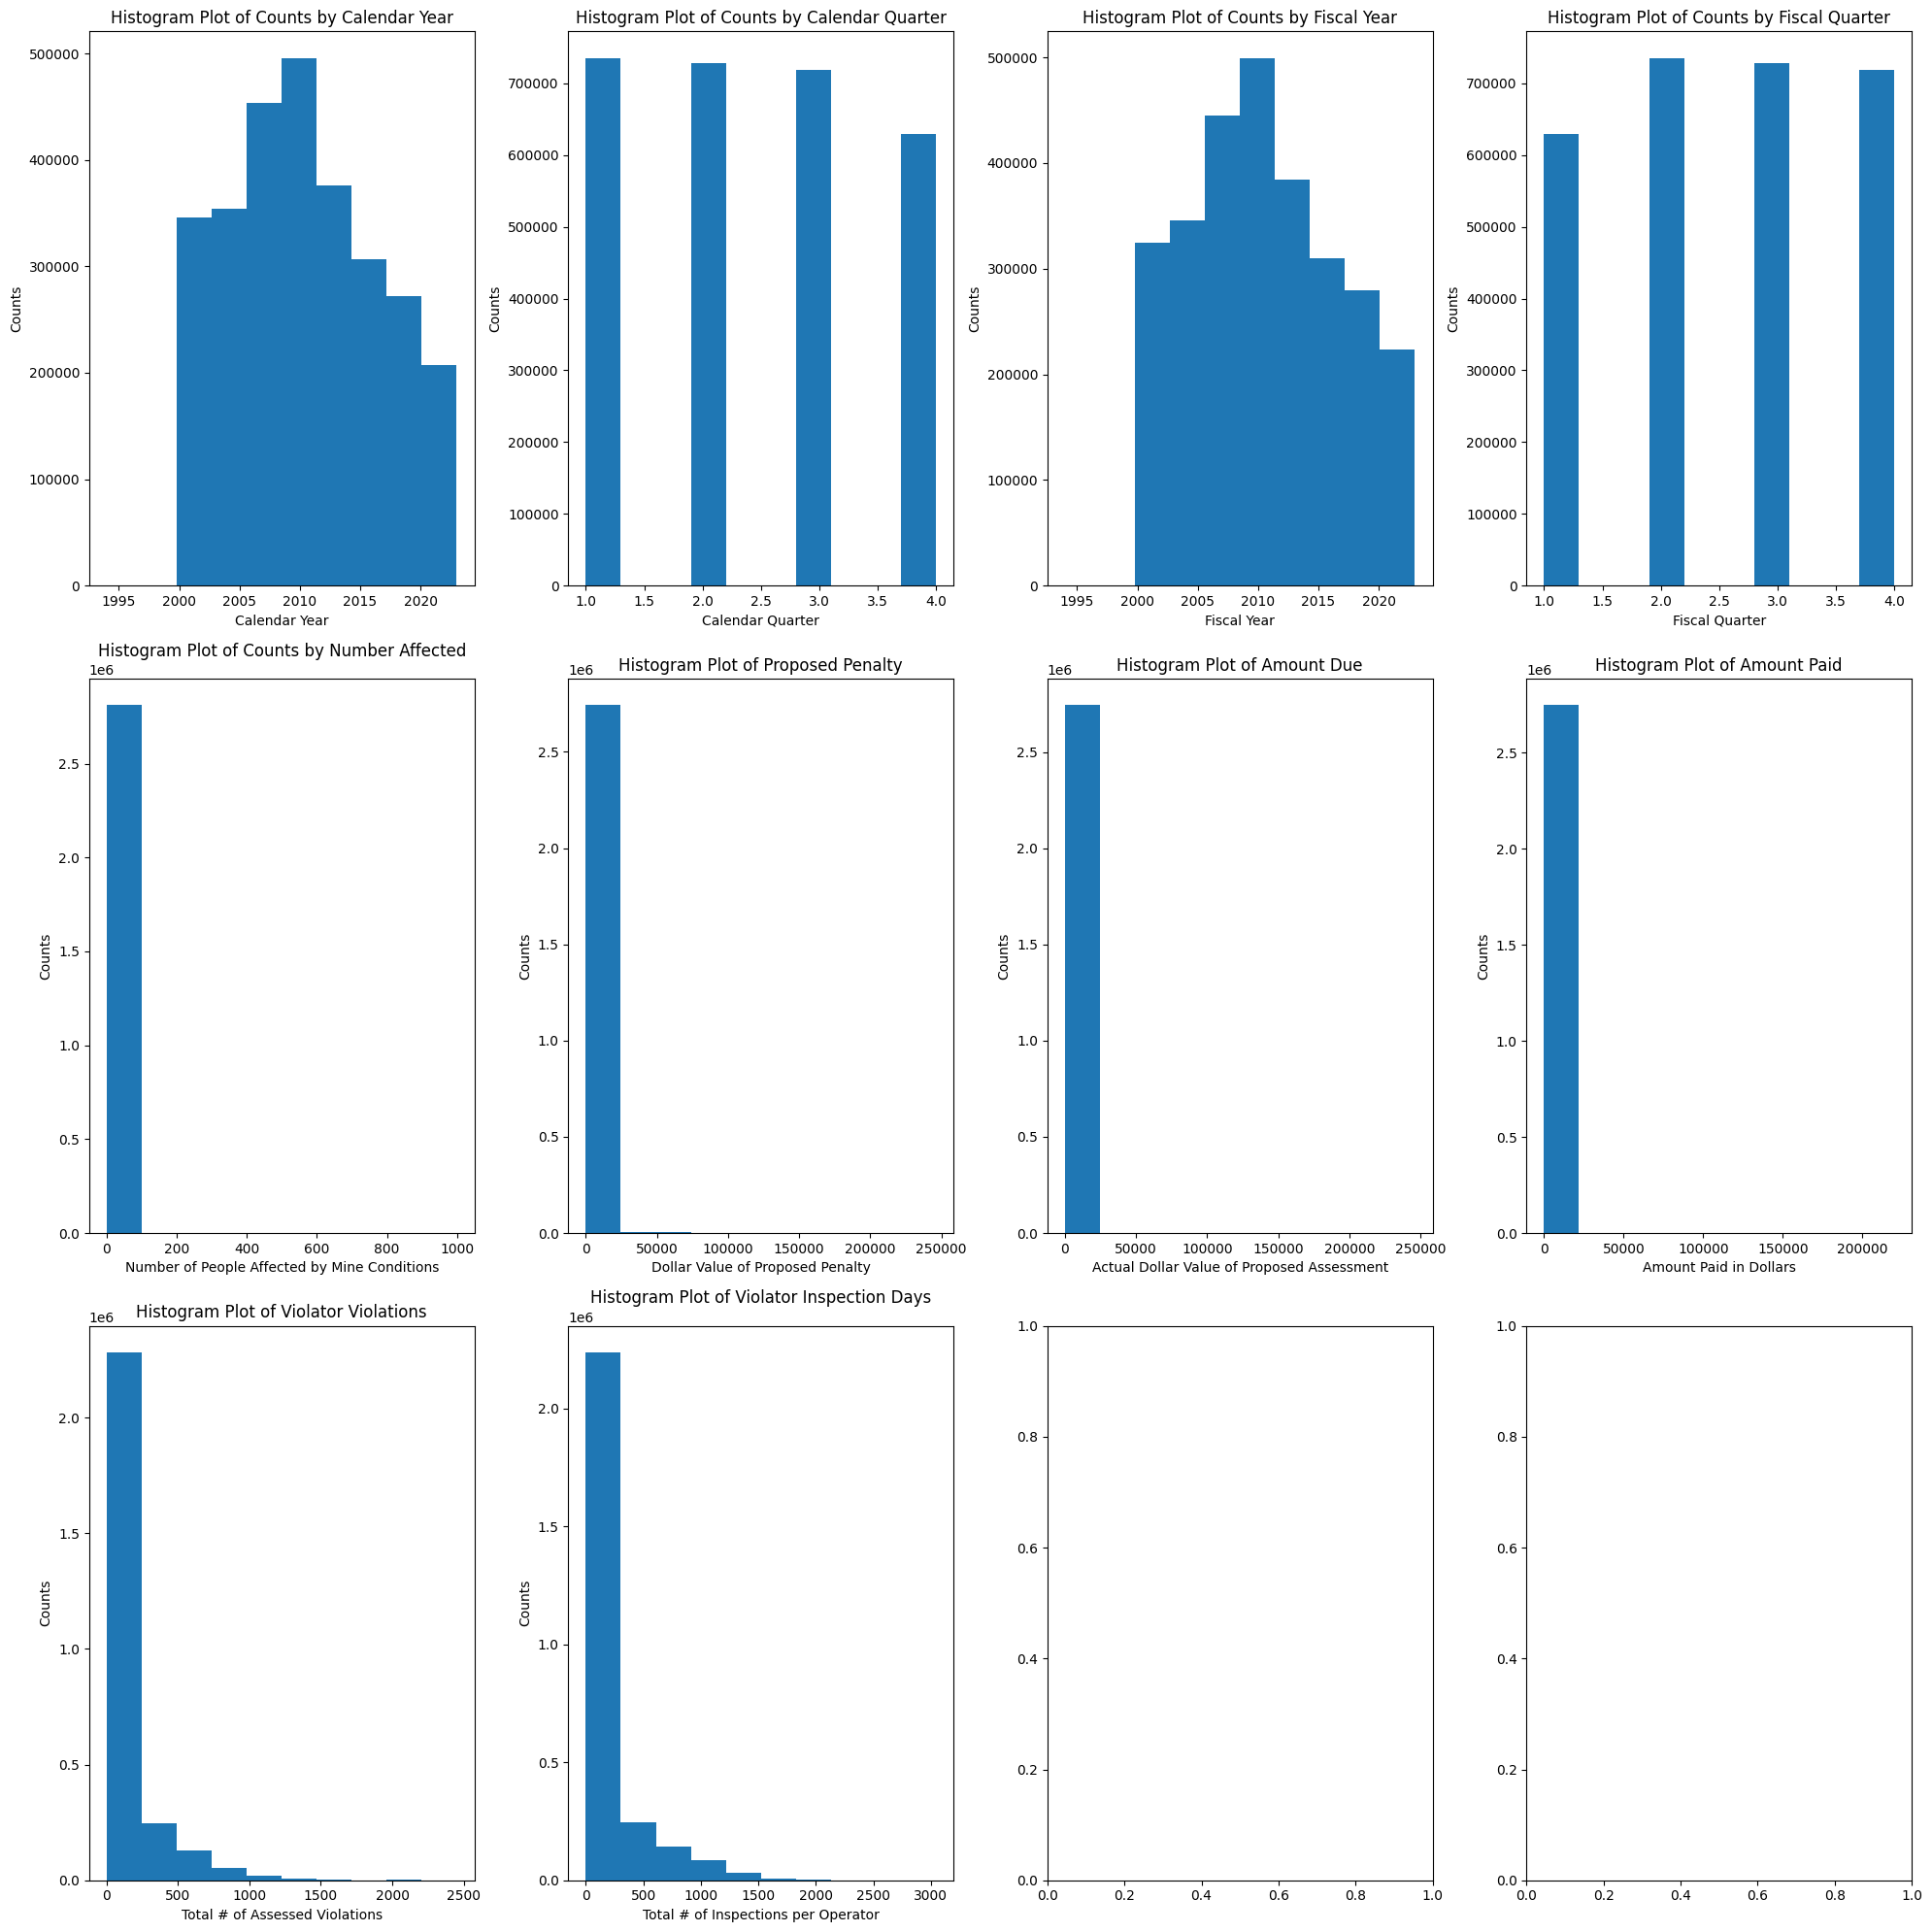

In [9]:
# Scatter plots of numerical variables in violations df

# Setting subplot dimensions and figure size of each plot
fig, axs = plt.subplots(3, 4, figsize = (20, 20))

# cal_yr histogram
axs[0,0].hist(violations['CAL_YR'])
axs[0,0].set_xlabel('Calendar Year')
axs[0,0].set_ylabel('Counts')
axs[0,0].set_title('Histogram Plot of Counts by Calendar Year')

# cal_qtr histogram
axs[0,1].hist(violations['CAL_QTR'])
axs[0,1].set_xlabel('Calendar Quarter')
axs[0,1].set_ylabel('Counts')
axs[0,1].set_title('Histogram Plot of Counts by Calendar Quarter')

# fiscal_yr histogram
axs[0,2].hist(violations['FISCAL_YR'])
axs[0,2].set_xlabel('Fiscal Year')
axs[0,2].set_ylabel('Counts')
axs[0,2].set_title('Histogram Plot of Counts by Fiscal Year')

# fiscal_qtr histogram
axs[0,3].hist(violations['FISCAL_QTR'])
axs[0,3].set_xlabel('Fiscal Quarter')
axs[0,3].set_ylabel('Counts')
axs[0,3].set_title('Histogram Plot of Counts by Fiscal Quarter')

# no_affected histogram
axs[1,0].hist(violations['NO_AFFECTED'])
axs[1,0].set_xlabel('Number of People Affected by Mine Conditions')
axs[1,0].set_ylabel('Counts')
axs[1,0].set_title('Histogram Plot of Counts by Number Affected')

# proposed_penalty histogram
axs[1,1].hist(violations['PROPOSED_PENALTY'])
axs[1,1].set_xlabel('Dollar Value of Proposed Penalty')
axs[1,1].set_ylabel('Counts')
axs[1,1].set_title('Histogram Plot of Proposed Penalty')

# amount_due histogram
axs[1,2].hist(violations['AMOUNT_DUE'])
axs[1,2].set_xlabel('Actual Dollar Value of Proposed Assessment')
axs[1,2].set_ylabel('Counts')
axs[1,2].set_title('Histogram Plot of Amount Due')

# amount_paid histogram
axs[1,3].hist(violations['AMOUNT_PAID'])
axs[1,3].set_xlabel('Amount Paid in Dollars')
axs[1,3].set_ylabel('Counts')
axs[1,3].set_title('Histogram Plot of Amount Paid')

# violator_violation_cnt histogram
axs[2,0].hist(violations['VIOLATOR_VIOLATION_CNT'])
axs[2,0].set_xlabel('Total # of Assessed Violations')
axs[2,0].set_ylabel('Counts')
axs[2,0].set_title('Histogram Plot of Violator Violations')

# violator_inspection_day_cnt histogram
axs[2,1].hist(violations['VIOLATOR_INSPECTION_DAY_CNT'])
axs[2,1].set_xlabel('Total # of Inspections per Operator')
axs[2,1].set_ylabel('Counts')
axs[2,1].set_title('Histogram Plot of Violator Inspection Days')

plt.tight_layout()
plt.show()

INSIGHTS 

Violations are going down (since 2010 really).

There are less violations in Q4 (might need to remove 2023 to confirm that).

All other graphs are heavily right skewed. Need to dive in further to see if there are any outliers that need to be removed and what the real data picture is.

#### Number Affected

This is a measure of the number of persons affected or potentially affected by the conditions at the Mine due to the violation.  Can be zero.

In [10]:
# Descriptive statistics of 'NO_AFFECTED' variable in violations df
violations.NO_AFFECTED.describe()

count    2.812757e+06
mean     1.481975e+00
std      6.266838e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.990000e+02
Name: NO_AFFECTED, dtype: float64

In [11]:
# Printing skewness and kurtosis of 'NO_AFFECTED' variable in violations df
print(f"Skewness: {violations['NO_AFFECTED'].skew()}")
print(f"Kurtosis: {violations['NO_AFFECTED'].kurt()}")

Skewness: 123.18769580253895
Kurtosis: 18945.803369299865


In [12]:
# violations[violations['NO_AFFECTED'] == 999]
no_affected_counts = pd.DataFrame(violations['NO_AFFECTED'].value_counts()).reset_index()
no_affected_counts.sort_values(by = 'NO_AFFECTED', ascending= False).head(5)

,NO_AFFECTED,count
61,999,20
41,998,59
128,991,2
209,900,1
158,812,1


In [13]:
max_index = violations[['NO_AFFECTED']].idxmax()
max_value = violations['NO_AFFECTED'].iloc[max_index[0]]
print(f"The largest value of NO_AFFECTED is at index : {max_index[0]}, with a value of: {max_value}")

The largest value of NO_AFFECTED is at index : 2355192, with a value of: 999


In [15]:
# pd.set_option('display.max_rows', None)

# print(violations[['NO_AFFECTED']].idxmax())
# print(violations.iloc[2356982])

# pd.reset_option('display.max_rows')

INSIGHT: The average number affected is 1.5. The min is 0. The max is 999 - might want to look into that violation.
    
- There are 20 violations with max NO_AFFECTED == 999. I want to say this is a null value but there are also records with 998, 991, 900, etc. 

#### Proposed Penalty

The original dollar value of the proposed penalty prior to any modifications such as those possibly resulting from a decision on a contested case.

In [16]:
# Descriptive statistics of 'PROPOSED_PENALTY' variable in violations df
violations.PROPOSED_PENALTY.describe()

count    2.749690e+06
mean     5.890649e+02
std      3.111682e+03
min      1.000000e+00
25%      1.000000e+02
50%      1.230000e+02
75%      3.080000e+02
max      2.462000e+05
Name: PROPOSED_PENALTY, dtype: float64

In [17]:
# Printing skewness and kurtosis of 'PROPOSED_PENALTY' variable in violations df
print(f"Skewness: {violations['PROPOSED_PENALTY'].skew()}")
print(f"Kurtosis: {violations['PROPOSED_PENALTY'].kurt()}")

Skewness: 25.357471822941505
Kurtosis: 1038.3462147606333


INSIGHT: The average proposed penalty is 589.10 dollars. The min is 100 dollars and the max is 246,200 dollars - might want to look into that violation.

In [18]:
max_index = violations[['PROPOSED_PENALTY']].idxmax()
max_value = violations['PROPOSED_PENALTY'].iloc[max_index[0]]
print(f"The largest value of PROPOSED_PENALTY is at index : {max_index[0]}, with a value of: ${max_value}")

The largest value of PROPOSED_PENALTY is at index : 497638, with a value of: $246200.0


In [19]:
# pd.set_option('display.max_rows', None)

# print(violations[['PROPOSED_PENALTY']].idxmax())
# print(violations.iloc[498123])

# pd.reset_option('display.max_rows')

INSIGHT: The violation with the highest penalty is a highly likekly, fatal accident that waas characterized by reckless negligence.

#### Amount Due

The current dollar value of the proposed assessment, reflecting any modifications that have been made since it was originally assessed.

In [20]:
# Descriptive statistics of 'AMOUNT_DUE' varibale in violations df
violations.AMOUNT_DUE.describe()

count    2.749690e+06
mean     4.720882e+02
std      2.254934e+03
min      0.000000e+00
25%      1.000000e+02
50%      1.230000e+02
75%      2.860000e+02
max      2.462000e+05
Name: AMOUNT_DUE, dtype: float64

In [21]:
# Printing skewness and kurtosis of 'AMOUNT_DUE' variable in violations df
print(f"Skewness: {violations['AMOUNT_DUE'].skew()}")
print(f"Kurtosis: {violations['AMOUNT_DUE'].kurt()}")

Skewness: 31.599053701732068
Kurtosis: 1819.0014472680868


In [22]:
max_index = violations[['AMOUNT_DUE']].idxmax()
max_value = violations['AMOUNT_DUE'].iloc[max_index[0]]
print(f"The largest value of AMOUNT_DUE is at index : {max_index[0]}, with a value of: ${max_value}")

The largest value of AMOUNT_DUE is at index : 497638, with a value of: $246200.0


INSIGHT: The average amount due is 472.15 dollars. The min is 0 dollars and the max is 246,200 dollars.

#### Amount Paid

The total dollar value of all payments applied to this proposed assessment to date.

In [23]:
# Descriptive statistics of 'AMOUNT_PAID' variable in violations df
violations.AMOUNT_PAID.describe()

count    2.749690e+06
mean     4.070087e+02
std      1.887374e+03
min      0.000000e+00
25%      6.000000e+01
50%      1.170000e+02
75%      2.630000e+02
max      2.200000e+05
Name: AMOUNT_PAID, dtype: float64

In [24]:
# Printing skewness and kurtosis of 'AMOUNT_PAID' variable in violations df
print(f"Skewness: {violations['AMOUNT_PAID'].skew()}")
print(f"Kurtosis: {violations['AMOUNT_PAID'].kurt()}")

Skewness: 36.288776294181865
Kurtosis: 2640.550806662077


INSIGHT: The average amount paid is 406.92 dollars. The min is 0 dollars and the max is 220,000 dollars.

#### Violator Violations

Total number of assessed violations for this violator at this time during the violation history period. Used in penalty calculation.  Applies to an Operator or a Contractor.

In [25]:
# Descriptive statistics of 'VIOLATOR_VIOLATION_CNT' variable in violations df
violations.VIOLATOR_VIOLATION_CNT.describe()

count    2.749690e+06
mean     1.231055e+02
std      2.281404e+02
min      0.000000e+00
25%      1.000000e+00
50%      1.500000e+01
75%      1.350000e+02
max      2.452000e+03
Name: VIOLATOR_VIOLATION_CNT, dtype: float64

In [26]:
# Printing skewness and kurtosis of 'VIOLATOR_VIOLATION_CNT' variable in violations df
print(f"Skewness: {violations['VIOLATOR_VIOLATION_CNT'].skew()}")
print(f"Kurtosis: {violations['VIOLATOR_VIOLATION_CNT'].kurt()}")

Skewness: 2.8629613360337864
Kurtosis: 10.353812836595168


INSIGHT: The average number of violations is 123. The min is 0 and the max is 2452. That's a lot of violations!

#### Violator Inspection Days

Total number of inspections for this Operator at a mine during the violation history period. Used in penalty calculation. Does not apply to Contractor.

In [27]:
# Descriptive statistics of 'VIOLATOR_INSPECTION_DAY_CNT' variable in violations df
violations.VIOLATOR_INSPECTION_DAY_CNT.describe()

count    2.749690e+06
mean     1.673952e+02
std      3.010801e+02
min      0.000000e+00
25%      1.000000e+00
50%      1.800000e+01
75%      1.780000e+02
max      3.044000e+03
Name: VIOLATOR_INSPECTION_DAY_CNT, dtype: float64

In [28]:
# Printing skewness and kurtosis of 'VIOLATOR_INSPECTION_DAY_CNT' in violations df
print(f"Skewness: {violations['VIOLATOR_INSPECTION_DAY_CNT'].skew()}")
print(f"Kurtosis: {violations['VIOLATOR_INSPECTION_DAY_CNT'].kurt()}")

Skewness: 2.4310195679767457
Kurtosis: 6.338211719893775


INSIGHT: The average number of inspections is 167. The min is 0 and the max is 3044. That's a lot of inspections!

#### Pairwise Plots

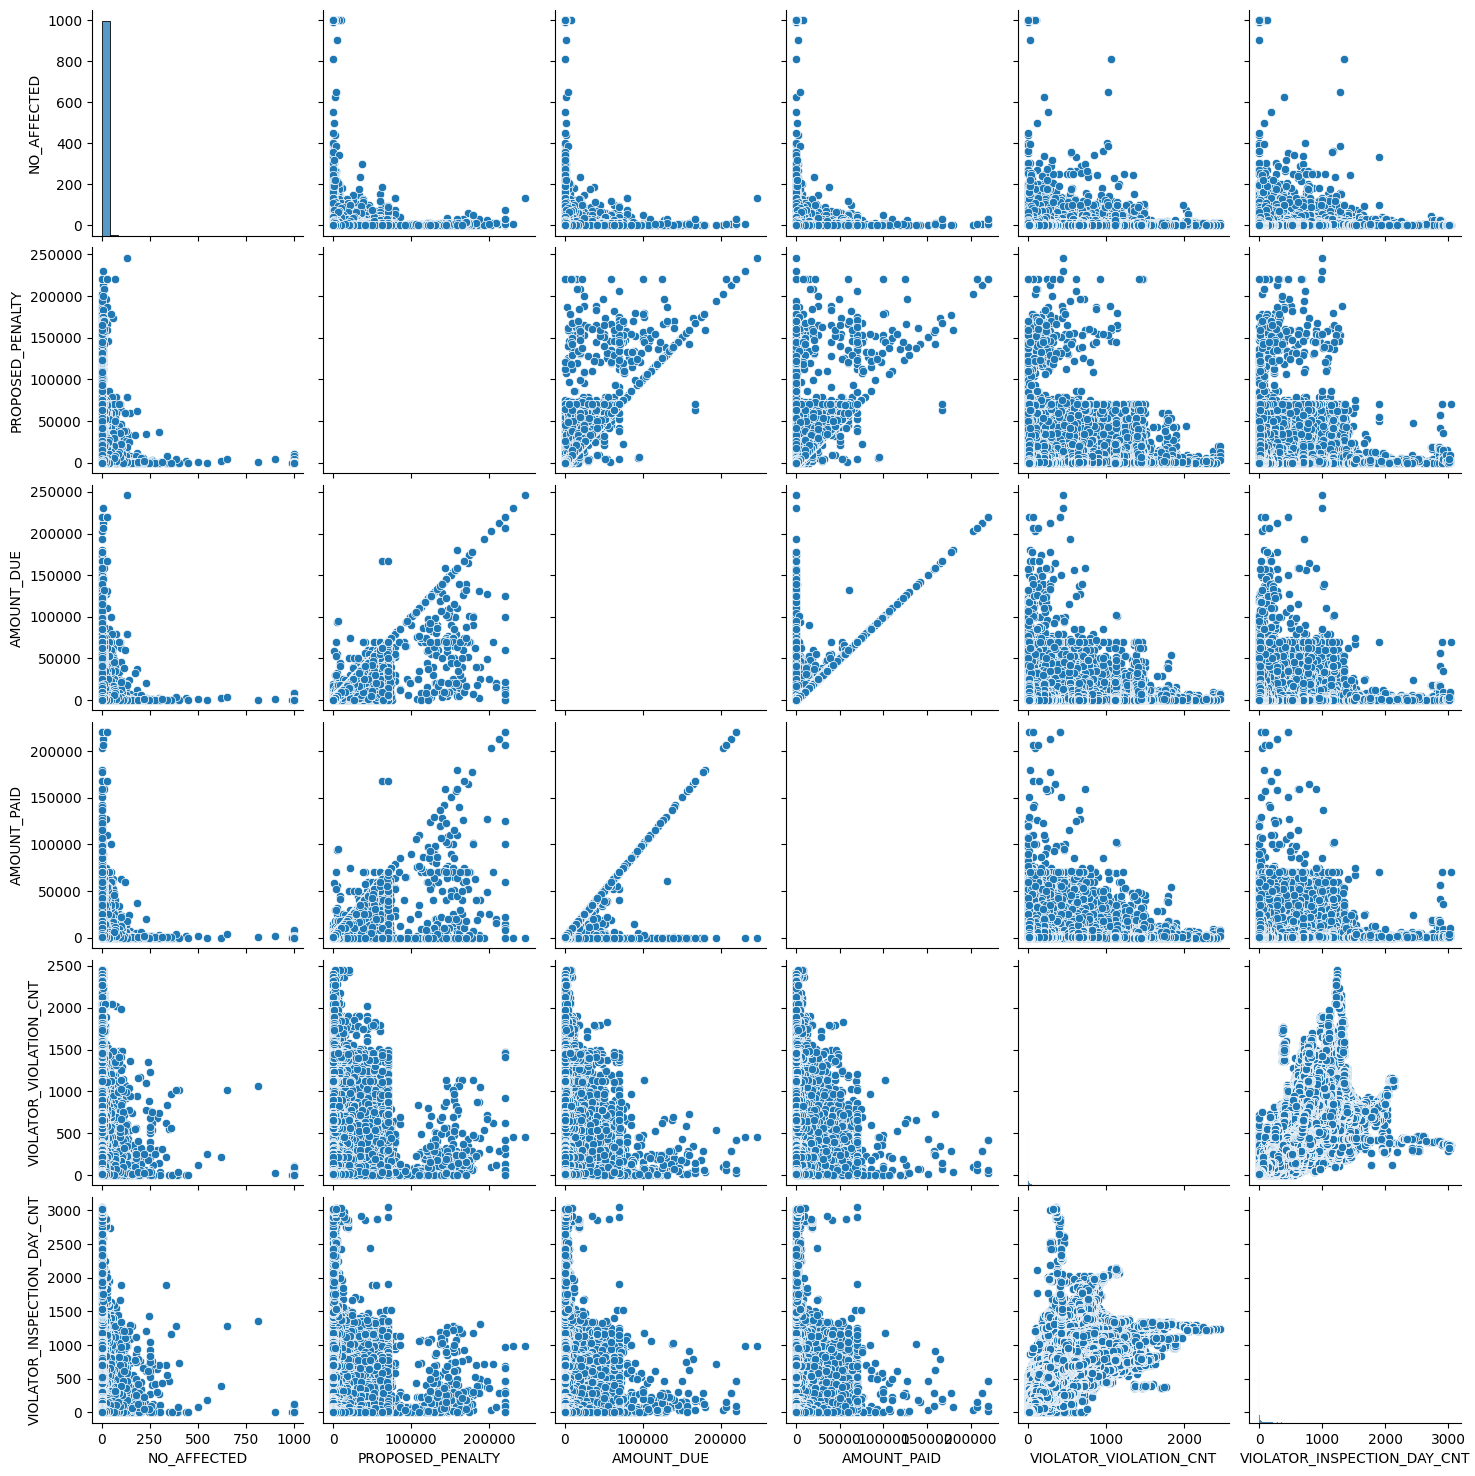

In [29]:
# Plotting a pairwise plot of numeric variables in violations df to view possible correlations

# Creating subset of numeric variables in violations df
numeric_vars = violations[['NO_AFFECTED', 
                           'PROPOSED_PENALTY', 
                           'AMOUNT_DUE', 
                           'AMOUNT_PAID', 
                           'VIOLATOR_VIOLATION_CNT', 
                           'VIOLATOR_INSPECTION_DAY_CNT']]

# Creating a pairwise scatterplot matrix of numeric_vars
sns.pairplot(numeric_vars)

# Viewing the pairwise plot
plt.show()

#### Correlation

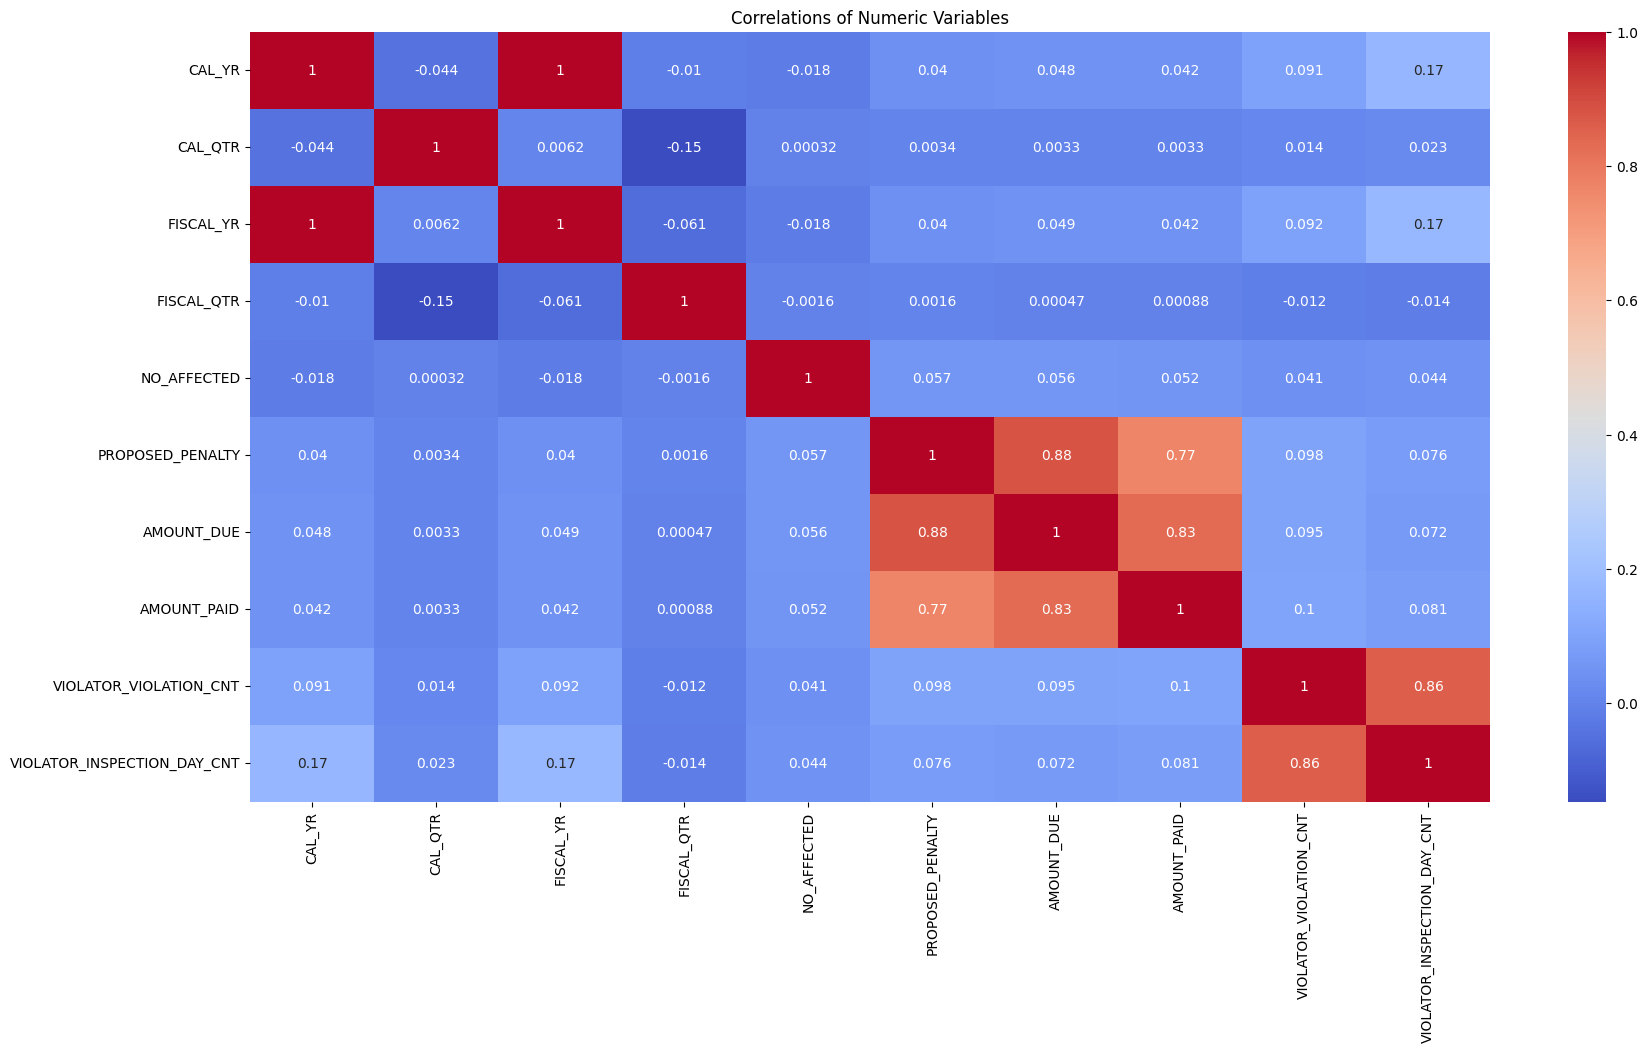

In [30]:
# Correlation matrix of numeric variables in violations df to view correlation coefficients

# Creating subset of numeric variables in violations df
numeric_vars = violations[['CAL_YR', 
                           'CAL_QTR', 
                           'FISCAL_YR', 
                           'FISCAL_QTR', 
                           'NO_AFFECTED', 
                           'PROPOSED_PENALTY', 
                           'AMOUNT_DUE', 
                           'AMOUNT_PAID', 
                           'VIOLATOR_VIOLATION_CNT', 
                           'VIOLATOR_INSPECTION_DAY_CNT']]

# Creating correlation matrix from numeric_vars
corr_matrix = numeric_vars.corr()

# Set the figure size to prevent overlapping
plt.figure(figsize=(20, 10))

# Create and show heatmap - add fontsize parameter
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={'fontsize': 10})

# Setting title
plt.title('Correlations of Numeric Variables')

# Viewing the heatmap
plt.show()

INSIGHTS:
PROPOSED_PENALTY, AMOUNT_DUE, and AMOUNT_PAID are highly correlated, which is expected. 

Would argue that NO_AFFECTED is one of the key numeric variables and does not seem at all correlated with any other numeric variables.

Number of violations (VIOLATOR__VIOLATION_CNT) is supposed to inform penalties but their correlation is only 0.10.

Need to remove either FISCAL or CAL, not getting any new info there. 

### Categorical EDA

#### Overall Visualizations

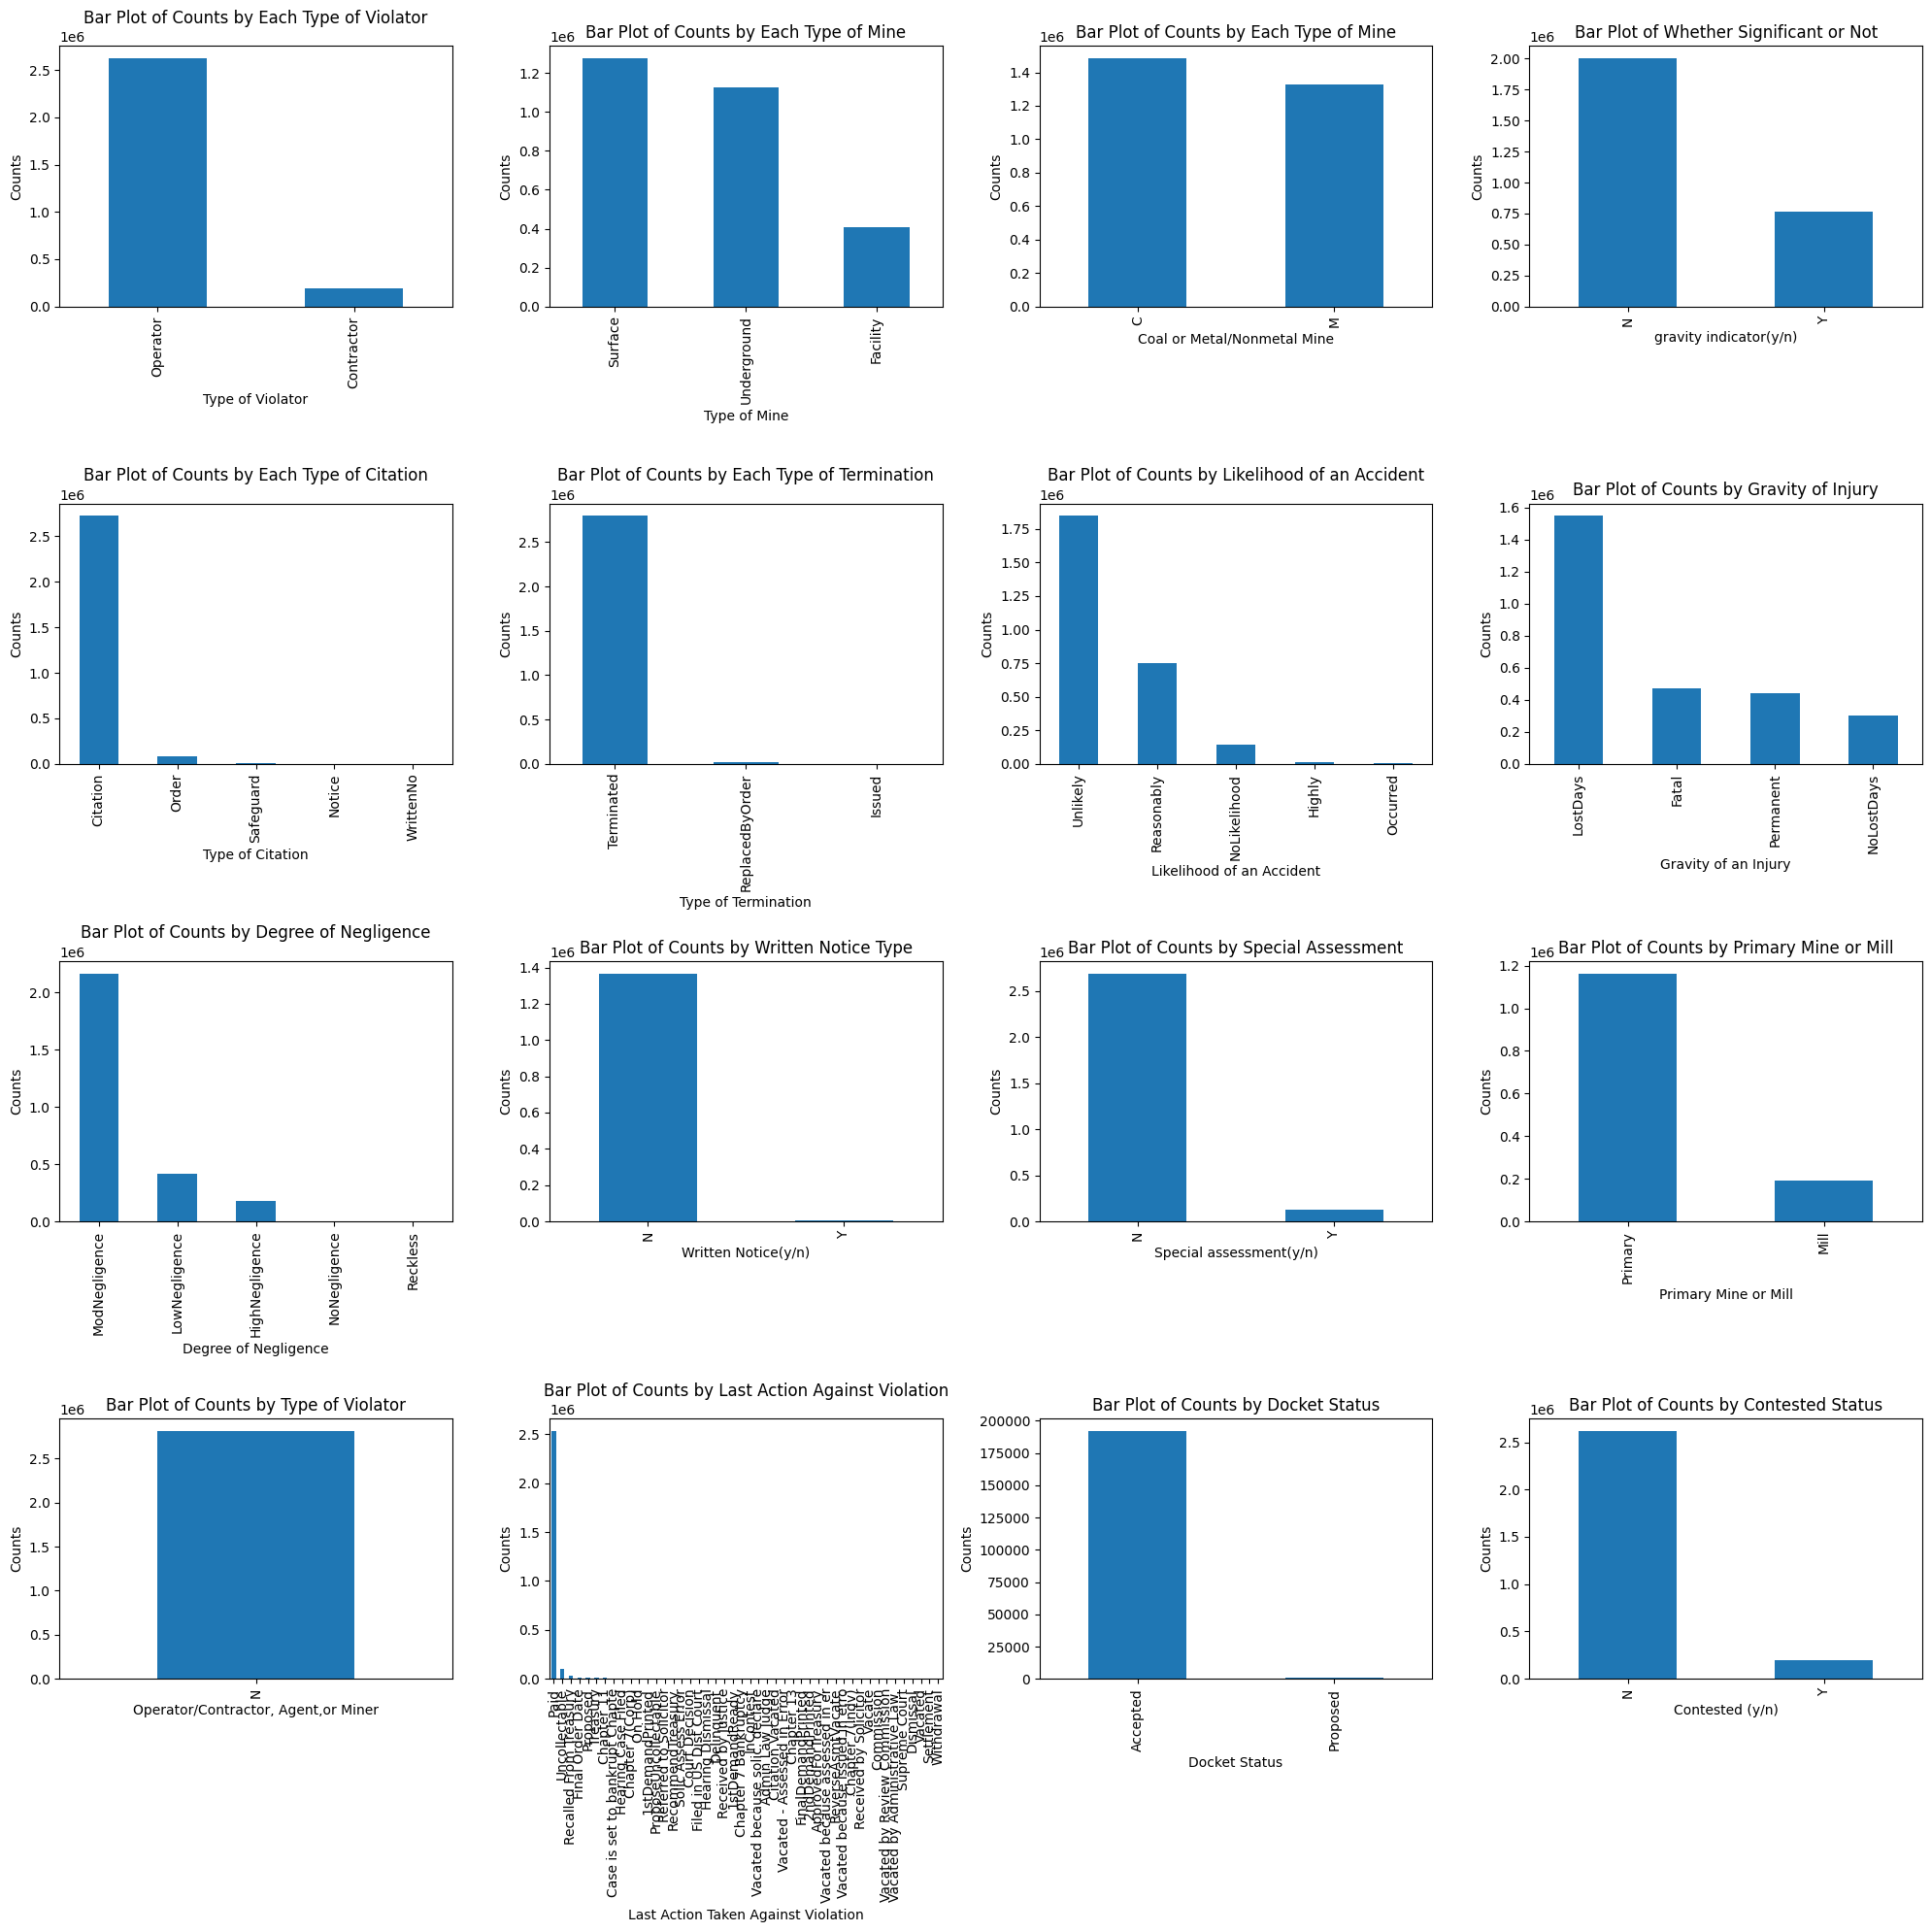

In [31]:
# Bar plots of categorical and binary variables in violations df

# Setting subplot dimensions 
fig, axs = plt.subplots(4, 4, figsize = (20, 20))

# violator_type_cd bar chart
violations['VIOLATOR_TYPE_CD'].value_counts().plot(kind = 'bar', ax = axs[0,0])
axs[0,0].set_xlabel('Type of Violator')
axs[0,0].set_ylabel('Counts')
axs[0,0].set_title('Bar Plot of Counts by Each Type of Violator')

# mine_type bar chart
violations['MINE_TYPE'].value_counts().plot(kind = 'bar', ax = axs[0,1])
axs[0,1].set_xlabel('Type of Mine')
axs[0,1].set_ylabel('Counts')
axs[0,1].set_title('Bar Plot of Counts by Each Type of Mine')

# coal_metal_ind bar chart
violations['COAL_METAL_IND'].value_counts().plot(kind = 'bar', ax = axs[0,2])
axs[0,2].set_xlabel('Coal or Metal/Nonmetal Mine')
axs[0,2].set_ylabel('Counts')
axs[0,2].set_title('Bar Plot of Counts by Each Type of Mine')

# Sig_sub bar chart
violations['SIG_SUB'].value_counts().plot(kind = 'bar', ax = axs[0,3])
axs[0,3].set_xlabel('gravity indicator(y/n)')
axs[0,3].set_ylabel('Counts')
axs[0,3].set_title('Bar Plot of Whether Significant or Not')

# city_ord_safe bar chart
violations['CIT_ORD_SAFE'].value_counts().plot(kind = 'bar', ax = axs[1,0])
axs[1,0].set_xlabel('Type of Citation')
axs[1,0].set_ylabel('Counts')
axs[1,0].set_title('Bar Plot of Counts by Each Type of Citation')

# termination_type bar chart
violations['TERMINATION_TYPE'].value_counts().plot(kind = 'bar', ax = axs[1,1])
axs[1,1].set_xlabel('Type of Termination')
axs[1,1].set_ylabel('Counts')
axs[1,1].set_title('Bar Plot of Counts by Each Type of Termination')

# likelihood bar chart
violations['LIKELIHOOD'].value_counts().plot(kind = 'bar', ax = axs[1,2])
axs[1,2].set_xlabel('Likelihood of an Accident')
axs[1,2].set_ylabel('Counts')
axs[1,2].set_title('Bar Plot of Counts by Likelihood of an Accident')

# inJ_illness bar chart
violations['INJ_ILLNESS'].value_counts().plot(kind = 'bar', ax = axs[1,3])
axs[1,3].set_xlabel('Gravity of an Injury')
axs[1,3].set_ylabel('Counts')
axs[1,3].set_title('Bar Plot of Counts by Gravity of Injury')

# negligence bar chart
violations['NEGLIGENCE'].value_counts().plot(kind = 'bar', ax = axs[2,0])
axs[2,0].set_xlabel('Degree of Negligence')
axs[2,0].set_ylabel('Counts')
axs[2,0].set_title('Bar Plot of Counts by Degree of Negligence')

# written_notice bar chart
violations['WRITTEN_NOTICE'].value_counts().plot(kind = 'bar', ax = axs[2,1])
axs[2,1].set_xlabel('Written Notice(y/n)')
axs[2,1].set_ylabel('Counts')
axs[2,1].set_title('Bar Plot of Counts by Written Notice Type')

# enforcement_area bar chart
violations['ENFORCEMENT_AREA'].value_counts().plot(kind = 'bar', ax = axs[2,2])
axs[2,2].set_xlabel('Enforcement Area Affected')
axs[2,2].set_ylabel('Counts')
axs[2,2].set_title('Bar Plot of Counts by Enforcement Area Affected')

# special_assess bar chart
violations['SPECIAL_ASSESS'].value_counts().plot(kind = 'bar', ax = axs[2,2])
axs[2,2].set_xlabel('Special assessment(y/n)')
axs[2,2].set_ylabel('Counts')
axs[2,2].set_title('Bar Plot of Counts by Special Assessment')

# primary_or_mill bar chart
violations['PRIMARY_OR_MILL'].value_counts().plot(kind = 'bar', ax = axs[2,3])
axs[2,3].set_xlabel('Primary Mine or Mill')
axs[2,3].set_ylabel('Counts')
axs[2,3].set_title('Bar Plot of Counts by Primary Mine or Mill')

# asmt_generated_ind bar chart
violations['ASMT_GENERATED_IND'].value_counts().plot(kind = 'bar', ax = axs[3,0])
axs[3,0].set_xlabel('Operator/Contractor, Agent,or Miner')
axs[3,0].set_ylabel('Counts')
axs[3,0].set_title('Bar Plot of Counts by Type of Violator')

# last_action_cd bar chart
violations['LAST_ACTION_CD'].value_counts().plot(kind = 'bar', ax = axs[3,1])
axs[3,1].set_xlabel('Last Action Taken Against Violation')
axs[3,1].set_ylabel('Counts')
axs[3,1].set_title('Bar Plot of Counts by Last Action Against Violation')

# docket_status_cd bar chart
violations['DOCKET_STATUS_CD'].value_counts().plot(kind = 'bar', ax = axs[3,2])
axs[3,2].set_xlabel('Docket Status')
axs[3,2].set_ylabel('Counts')
axs[3,2].set_title('Bar Plot of Counts by Docket Status')

# contested_ind bar chart
violations['CONTESTED_IND'].value_counts().plot(kind = 'bar', ax = axs[3,3])
axs[3,3].set_xlabel('Contested (y/n)')
axs[3,3].set_ylabel('Counts')
axs[3,3].set_title('Bar Plot of Counts by Contested Status')

plt.tight_layout()
plt.show()

INSIGHTS: 

By far, most violators are operators, not contractors. (Need to compare with inspections to see if this is due to differing volume of inspections).

Most mines are surface or underground, not facility.

Pretty even mix of coal and metal mines represented.

Apx. 1/3 of violations were likely to happen.

#### Violator Name

Name of the operator active at the time the violation was cited. May contain null values if this record pertains to a violation issued to a contractor.

In [33]:
# Value counts of 'VIOLATOR_NAME'
violations.VIOLATOR_NAME.value_counts()

VIOLATOR_NAME
Consolidation Coal Company          46004
Peabody Midwest Mining, LLC         21423
Rosebud Mining Company              16432
Marfork Coal Company, LLC           15549
Jim Walter Resources Inc            14798
                                    ...  
Shipman Construction Co                 1
Nashoba Stone LLC                       1
Alan Jeffery Trucking                   1
Optimum Electrical Services llc.        1
T&F Sand & Gravel Inc.                  1
Name: count, Length: 44577, dtype: int64

INSIGHT: Top operator violator is Consolidation Coal Company with over 46,000 violations!

#### Violator Type

Each Violator record represents an entity (Operator, Contractor, Agent or Miner) that has one or more violations at a mine.

In [34]:
# Normalized value (proportion of each value in the column) of 'VIOLATOR_TYPE_CD' variable in violations df
violations.VIOLATOR_TYPE_CD.value_counts(normalize = True)

VIOLATOR_TYPE_CD
Operator      0.932351
Contractor    0.067649
Name: proportion, dtype: float64

INSIGHT: 93% of violators are operators.

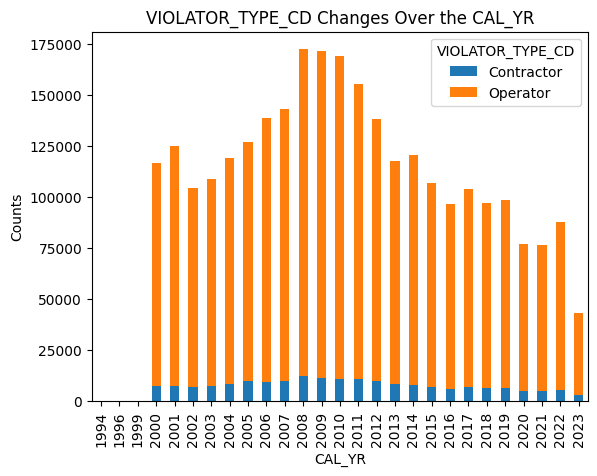

In [35]:
# Stacked bar plot of 'VIOLATOR_TYPE_CD' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'VIOLATOR_TYPE_CD' changes over the years

# Counting values grouped by CAL_YR and VIOLATOR_TYPE_CD
value_counts = violations.groupby('CAL_YR')['VIOLATOR_TYPE_CD'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('VIOLATOR_TYPE_CD Changes Over the CAL_YR')
plt.show()

INSIGHT: Overtime, operator's remain the main type of violator . Also, generally the number of operators is decreaisng overtime. 

#### Mine Type

Mine type of the mine where the violation has been issued:  Facility, Surface or Underground.

In [36]:
# Normalized value (proportion of each value in the column) of 'MINE_TYPE' in violations df
violations.MINE_TYPE.value_counts(normalize = True)

MINE_TYPE
Surface        0.453187
Underground    0.401084
Facility       0.145729
Name: proportion, dtype: float64

INSIGHT: 45% of violators are in surface mines, 40% are in underground, and only 14% in facility. Need to compare to mine types overall/inspection data.

##### Mine Type Comparison to Current Mine Type 

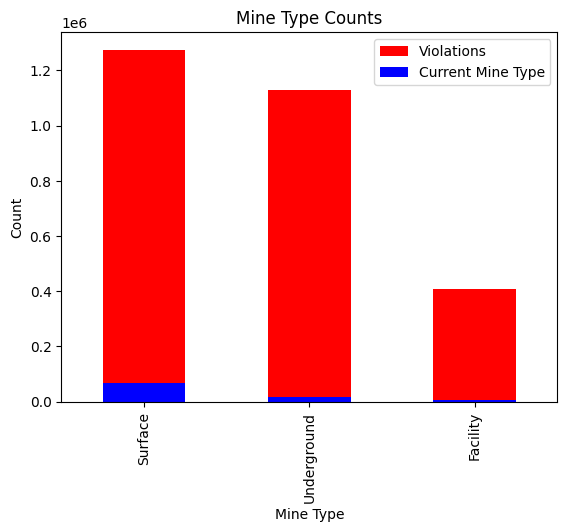

In [37]:
# Loading in mines dataset
mines = pd.read_csv('Mines.txt', sep= '|', encoding = 'latin-1')

# MINE_TYPE stacked bar plot with CURRENT_MINE_TYPE from Mines data
# Allows us to see the proportion of violations by 'MINE_TYPE' in the 'CURRENT_MINE_TYPE'

fig, ax = plt.subplots()

# Creating bar plot of 'MINE_TYPE' from violations df
violations['MINE_TYPE'].value_counts().plot(kind='bar', color='r', ax=ax, label='Violations', stacked=True)

# Creating bar plot of 'CURRENT_MINE_TYPE' from mines df
mines['CURRENT_MINE_TYPE'].value_counts().plot(kind='bar', color='b', ax=ax, label='Current Mine Type', stacked=True)

ax.set_xlabel('Mine Type')
ax.set_ylabel('Count')

# Setting bar plot title
ax.set_title('Mine Type Counts')

# Setting bar plot legend
ax.legend()

# Viewing the barplot
plt.show()

INSIGHT: We can see that the number of violations by mine_type is proportional to the overall mine types. So, it makes sense that surface mines have the largest number of violations and facility has the least number of violations. 

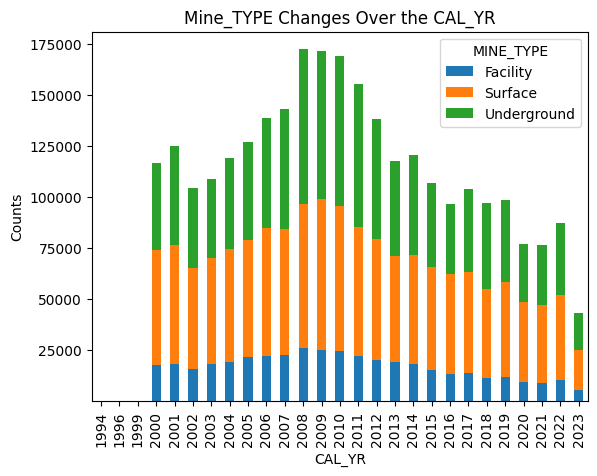

In [38]:
# Stacked bar plot of 'MINE_TYPE' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'MINE_TYPE' changes over the years

# Counting values grouped by CAL_YR and MINE_TYPE
value_counts = violations.groupby('CAL_YR')['MINE_TYPE'].value_counts().unstack()

# Creating bar plot of value counts 
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('Mine_TYPE Changes Over the CAL_YR')
plt.show()

INSIGHT: Proportions of MINE_TYPE's remain relatively stable overtime, which majority of mines being type Surface or Underground.

#### Coal or Metal

Identifies if the record is for a Coal or Metal/Non-Metal mine.

In [39]:
# Normalized value (proportion of each value in the column) of 'COAL_METAL_IND' in violations df
violations.COAL_METAL_IND.value_counts(normalize = True)

COAL_METAL_IND
C    0.527112
M    0.472888
Name: proportion, dtype: float64

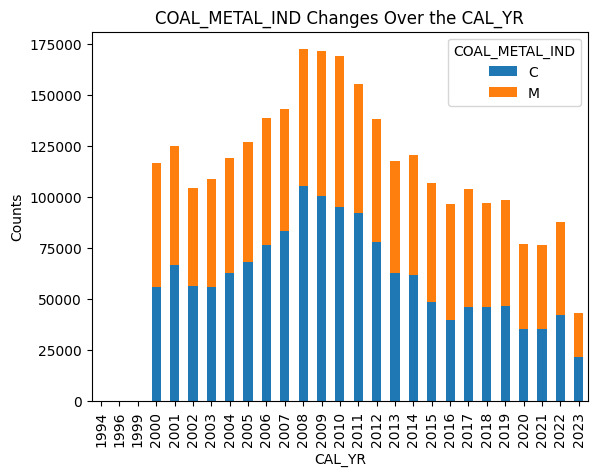

In [40]:
# Stacked bar plot of 'COAL_METAL_IND' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'COAL_METAL_IND' changes over the years

# Counting values grouped by CAL_YR and COAL_METAL_IND
value_counts = violations.groupby('CAL_YR')['COAL_METAL_IND'].value_counts().unstack()

# Creating bar plot of value counts 
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('COAL_METAL_IND Changes Over the CAL_YR')
plt.show()

INSIGHT: Surprisingly, the number of coal versus metal mines are close to equal (47% metal mines to 53% coal mines). Also, overtime would expect the number of coal mines to decrease more drastically than metal mines but that is not the case and the proportion of coal to metal mines remains pretty stable overtime. Note that there is a general trend of decreasing coal and metal mines.

#### Significant

An indicator as to whether or not the gravity is determined by the inspector to be significant and substantial.  If this is 'Y', the inspector has indicated that based upon the particular facts surrounding the violation there exists a reasonable likelihood the hazard contributed to will result in an injury or illness of a reasonably serious nature.

In [41]:
# Normalized value (proportion of each value in the column) of 'SIG_SUB' in violations df
violations.SIG_SUB.value_counts(normalize = True)

SIG_SUB
N    0.72303
Y    0.27697
Name: proportion, dtype: float64

INSIGHT: 72% of violations are not "significant or substantial". 

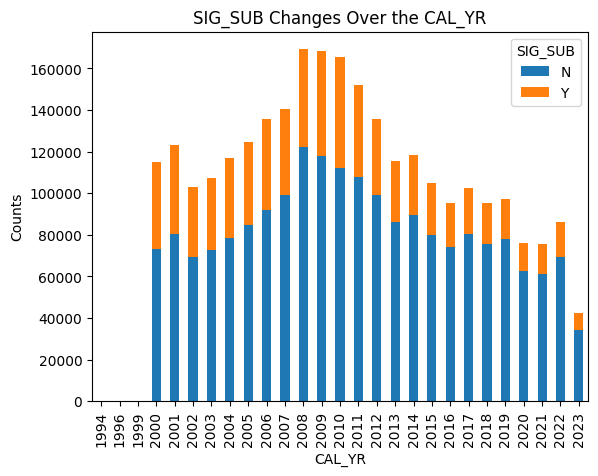

In [42]:
# Stacked bar plot of 'SIG_SUB' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'VIOLATOR_TYPE_CD' changes over the years

# Counting values grouped by CAL_YR and SIG_SUB
value_counts = violations.groupby('CAL_YR')['SIG_SUB'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('SIG_SUB Changes Over the CAL_YR')
plt.show()

#### City Ordinance

Specifies the type of Citation: Citation, Order, Safeguard, Written Notice or Notice.

In [43]:
# Normalized value (proportion of each value in the column) of 'CIT_ORD_SAFE' in violations df
violations.CIT_ORD_SAFE.value_counts(normalize = True)

CIT_ORD_SAFE
Citation     9.676662e-01
Order        2.958414e-02
Safeguard    2.746771e-03
Notice       2.133138e-06
WrittenNo    7.110461e-07
Name: proportion, dtype: float64

INSIGHT: 90% of violations are citations. Citations are a 'less serious' form of violation and does not require any immediate action by the mine. On the otherhand, Orders and Safeguards are much more serious violations and often require a mine shutdown. WrittenNo and Notice requires immediate action to fix the violation to avoid a mine shutdown.

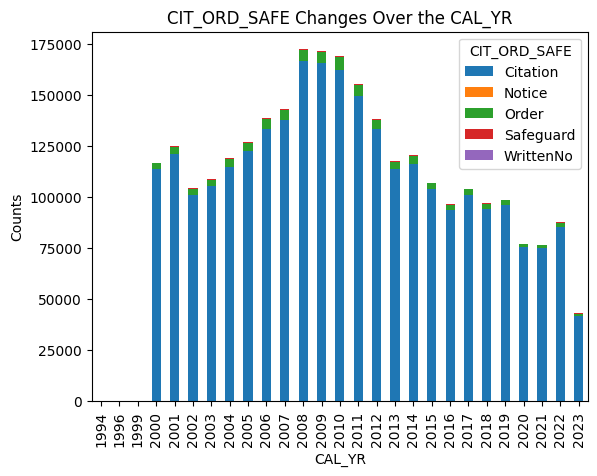

In [45]:
value_counts = violations.groupby('CAL_YR')['CIT_ORD_SAFE'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('CIT_ORD_SAFE Changes Over the CAL_YR')
plt.show()

INSIGHT: Majority of violations are citations, holds true overtime as well. Also, overtime, the number of orders seems to decrease which could indicate that mines are becoming safer since the types of violations are the less serious/impactful ones.

#### Termination Type

Code identifying the type of termination:  Issued, ReplacedByOrder or Terminated.

In [46]:
# Normalized value (proportion of each value in the column) of 'TERMINATION_TYPE' in violations df
violations.TERMINATION_TYPE.value_counts(normalize = True)

TERMINATION_TYPE
Terminated         0.993359
ReplacedByOrder    0.006149
Issued             0.000492
Name: proportion, dtype: float64

INSIGHT: 99% of violations are "Terminated" -- Not sure what it means that the citation was terminated. 

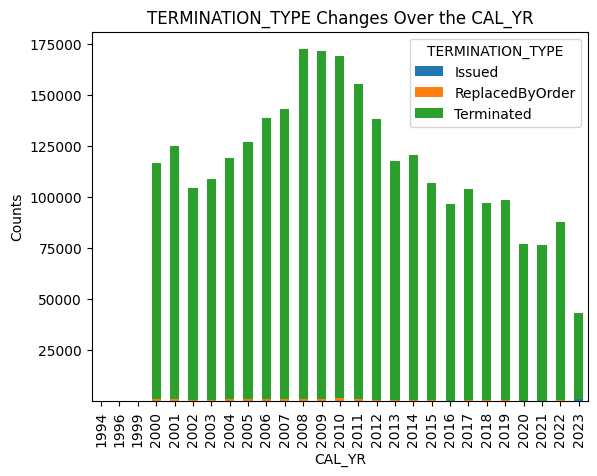

In [47]:
# Stacked bar plot of 'TERMINATION_TYPE' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'TERMINATION_TYPE' changes over the years

# Counting values grouped by CAL_YR and TERMINATION_TYPE
value_counts = violations.groupby('CAL_YR')['TERMINATION_TYPE'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('TERMINATION_TYPE Changes Over the CAL_YR')
plt.show()

#### Likelihood

This is a measure of the seriousness of the violation being cited as measured by the likelihood of the occurrence of an accident:  Highly, NoLikelihood, Occurred, Reasonably or Unlikely. May contain null values if situation does not apply.

In [48]:
# Normalized value (proportion of each value in the column) of 'LIKELIHOOD' in violations df
violations.LIKELIHOOD.value_counts(normalize = True)

LIKELIHOOD
Unlikely        0.667532
Reasonably      0.272034
NoLikelihood    0.052712
Highly          0.005482
Occurred        0.002239
Name: proportion, dtype: float64

INSIGHT: Primarily unlikely, some reasonable, very few of everything else.

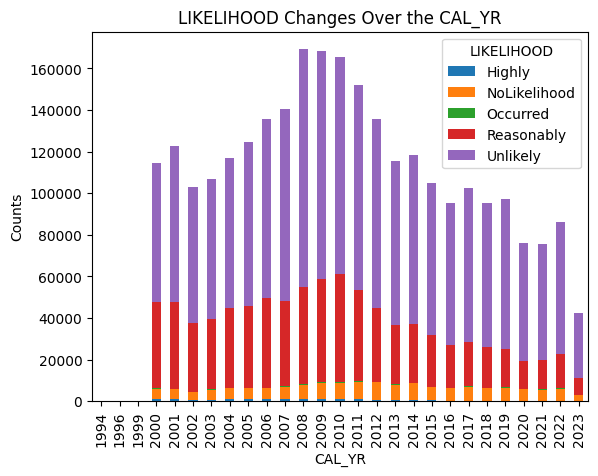

In [49]:
# Stacked bar plot of 'LIKELIHOOD' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'LIKELIHOOD ' changes over the years

# Counting values grouped by CAL_YR and LIKELIHOOD
value_counts = violations.groupby('CAL_YR')['LIKELIHOOD'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('LIKELIHOOD Changes Over the CAL_YR')
plt.show()

INSIGHT: This actually does seem like not only are violations going down but so are reasonably likely violations.

#### Inj_Illness

Value assigned to a violation for gravity of injury.  Measure of seriousness of violation being cited as measured by severity of the injury or illness to persons if accident were to occur due to the conditions of the violation: Fatal, LostDays, NoLostDays or Permanent.

In [50]:
# Normalized values (proportion of each value in the column) of 'INJ_ILLNESS' in violations df
violations.INJ_ILLNESS.value_counts(normalize = True)

INJ_ILLNESS
LostDays      0.559726
Fatal         0.170811
Permanent     0.159858
NoLostDays    0.109605
Name: proportion, dtype: float64

INSIGHT: Primarily lostdays, even mix of everything else.

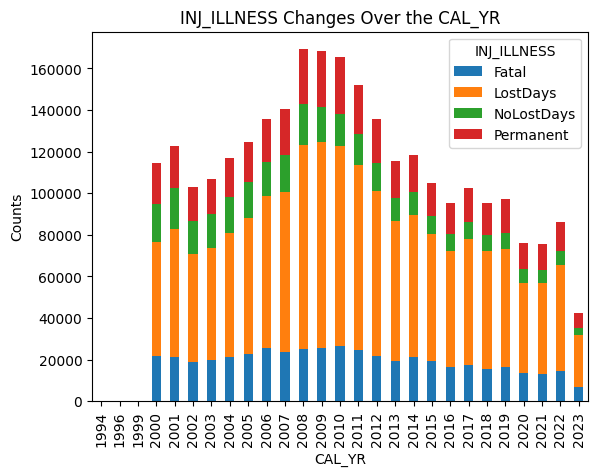

In [51]:
# Stacked bar plot of 'INJ_ILLNESS' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'INJ_ILLNESS' changes over the years

# Counting values grouped by CAL_YR and INJ_ILLNESS
value_counts = violations.groupby('CAL_YR')['INJ_ILLNESS'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('INJ_ILLNESS Changes Over the CAL_YR')
plt.show()

#### Negligence

Codes representing the degree of negligence that the Inspector assigned to the violator due to the violation:  HighNegligence, LowNegligence, ModNegligence, NoNegligence or Reckless. A high degree of negligence is assigned when the operator was in a position to be aware of the condition that contributed to a dangerous situation and there were no mitigating circumstances, or if there are unique aggravating circumstances associated with the violation, such as repeated past violations of the same standard at the mine.

In [52]:
# Normalized values (proportion of each value in the column) of 'NEGLIGENCE' in violations df
violations.NEGLIGENCE.value_counts(normalize = True)

NEGLIGENCE
ModNegligence     0.783884
LowNegligence     0.149816
HighNegligence    0.064228
NoNegligence      0.001350
Reckless          0.000722
Name: proportion, dtype: float64

INSIGHT: Primarily moderate negligence with the other types of negligence all pretty low.

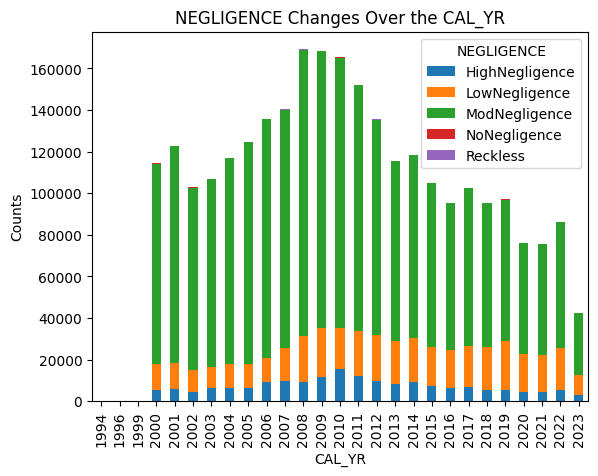

In [53]:
# Stacked bar plot of 'NEGLIGENCE' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'NEGLIGENCE' changes over the years

# Counting values grouped by CAL_YR and NEGLIGENCE
value_counts = violations.groupby('CAL_YR')['NEGLIGENCE'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('NEGLIGENCE Changes Over the CAL_YR')
plt.show()

#### Written Notice

Indicates if this citation is a result of a Miner or Agent notice of complaint to MSHA (written notice 103(g)):  ('Y'  or 'N').  May contain null values.

In [54]:
# Normalized value (proportion of each value in the column) of 'WRITTEN_NOTICE' in violations df
violations.WRITTEN_NOTICE.value_counts(normalize = True)

WRITTEN_NOTICE
N    0.996804
Y    0.003196
Name: proportion, dtype: float64

INSIGHT: Very few violations are the result of written complaints -- meaning they are likely the result of random inspections?

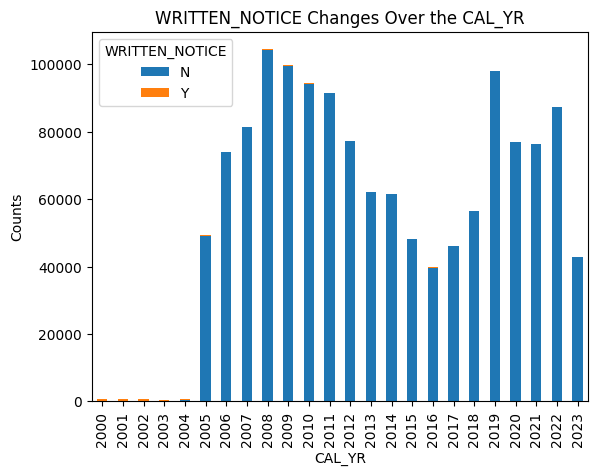

In [55]:
# Stacked bar plot of 'WRITTEN_NOTICE' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'WRITTEN_NOTICE' changes over the years

# Counting values grouped by CAL_YR and WRITTEN_NOTICE
value_counts = violations.groupby('CAL_YR')['WRITTEN_NOTICE'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('WRITTEN_NOTICE Changes Over the CAL_YR')
plt.show()

INSIGHT: No "No"s until 2005 -- random inspections must have started then.

#### Special Assessment

Specifies whether this citation has been designated for Special Assessment based on Special Assessment Review (Y or N).

In [56]:
# Normalized values (proportion of each value in the column) of 'SPECIAL_ASSESS' in violations df
violations.SPECIAL_ASSESS.value_counts(normalize = True)

SPECIAL_ASSESS
N    0.95584
Y    0.04416
Name: proportion, dtype: float64

INSIGHT: Very few violations are designated for Special Assessment -- what is Special Assessment? Is it something about the investigation or the violation? Like follow up required? Or weird type of observation, need it assessed as to whether its a violation or not?

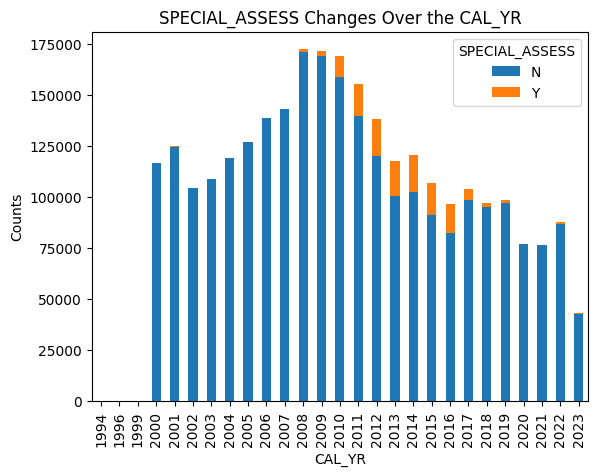

In [57]:
# Stacked bar plot of 'SPECIAL_ASSESS' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'SPECIAL_ASSESS' changes over the years

# Counting values grouped by CAL_YR and SPECIAL_ASSESS
value_counts = violations.groupby('CAL_YR')['SPECIAL_ASSESS'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('SPECIAL_ASSESS Changes Over the CAL_YR')
plt.show()

INSIGHT: Special assessment only really occured during the Obama administration.

#### Primary or Mill

A code indicating if the Violation was observed in the Primary Mine location or in an associated Mill (Metal/Non-Metal only). May contain null values.

In [58]:
# Normalized values (proportion of each value in the column) of 'PRIMARY_OR_MILL' in violations df
violations.PRIMARY_OR_MILL.value_counts(normalize = True)

PRIMARY_OR_MILL
Primary    0.857923
Mill       0.142077
Name: proportion, dtype: float64

INSIGHT: Most take place in the primary, which makes sense because the primary mill has the most activity.

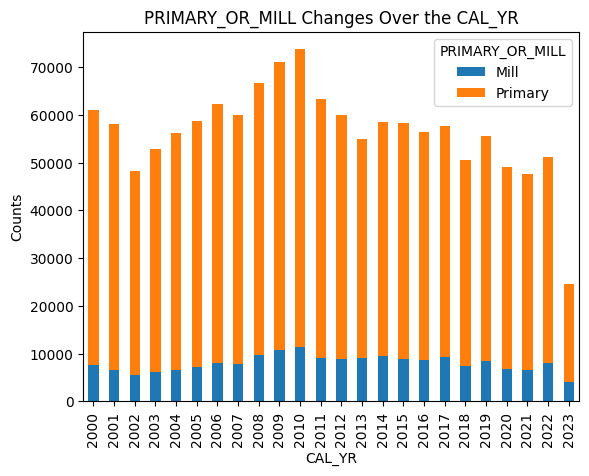

In [59]:
# Stacked bar plot of 'PRIMARY_OR_MILL' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'PRIMARY_OR_MILL' changes over the years

# Counting values grouped by CAL_YR and PRIMARY_OR_MILL
value_counts = violations.groupby('CAL_YR')['PRIMARY_OR_MILL'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('PRIMARY_OR_MILL Changes Over the CAL_YR')
plt.show()

#### Asmt Generated

If the violator is an Operator or Contractor, the indicator is 'N'. If the violator is an Agent, the indicator is 'Y'. If the violator is a Miner, the indicator can be 'Y' or 'N'. If none of the above, the indicator is '?'.

In [60]:
# Normalized values (proportion of each value in the column) of 'ASMT_GENERATED_IND' in violations df
violations.ASMT_GENERATED_IND.value_counts(normalize = True)

ASMT_GENERATED_IND
N    1.0
Name: proportion, dtype: float64

INSIGHT: Everything is N? Probably best to drop this column, I think our dataset must be a filtered dataset.

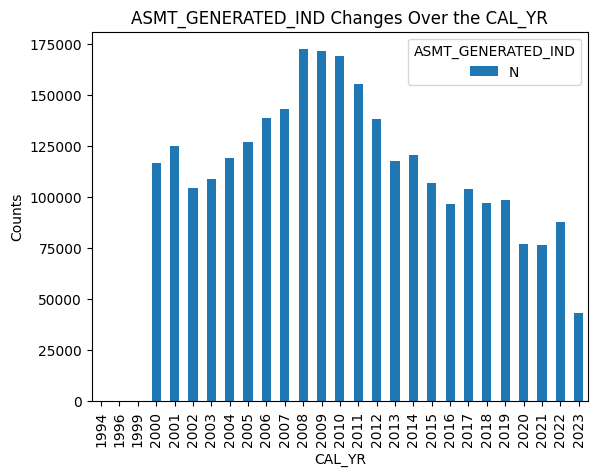

In [61]:
# Stacked bar plot of 'ASMT_GENERATED_IND' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'ASMT_GENERATED_IND' changes over the years

# Counting values grouped by CAL_YR and ASMT_GENERATED_IND
value_counts = violations.groupby('CAL_YR')['ASMT_GENERATED_IND'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('ASMT_GENERATED_IND Changes Over the CAL_YR')
plt.show()

#### Last Action

Last action taken against this violation such as 1stDemandPrinted, BillingReady, ApprovedforTreasury and Proposed.  

In [62]:
# Normalized values (proportion of each value in the column) of 'LAST_ACTION_CD' in violations df
violations.LAST_ACTION_CD.value_counts(normalize = True)

LAST_ACTION_CD
Paid                              9.218988e-01
Uncollectable                     3.708472e-02
Recalled From Treasury            1.154099e-02
Final Order Date                  5.743220e-03
Proposed                          5.641026e-03
Treasury                          5.032591e-03
Chapter 11                        4.181218e-03
Case is set to bankrupt Chapte    2.491202e-03
Hearing Case Filed                2.024238e-03
Chapter 7(Corp)                   6.382568e-04
On Hold                           5.891601e-04
1stDemandPrinted                  5.495191e-04
ProposeUncollectable              4.778743e-04
Referred to Solicitor             4.425974e-04
RecommendTreasury                 2.702136e-04
Solic Assess Error                2.189348e-04
Court Decision                    1.760207e-04
Filed in US Dist Court            1.749296e-04
Hearing Dismissal                 1.676561e-04
Delinquent                        1.221962e-04
Received by Justice               1.091037e-0

INSIGHT: Most are paid. 

#### Docket Status

Denotes the current status of this docket:  Approved (approved by the court) or Proposed (not yet been approved by the court).

In [63]:
# Normalized values (proportion of each value in the column) of 'DOCKET_STATUS_CD' in violations df
violations.DOCKET_STATUS_CD.value_counts(normalize = True)

DOCKET_STATUS_CD
Accepted    0.996387
Proposed    0.003613
Name: proportion, dtype: float64

INSIGHT: Basically everything is accepted.

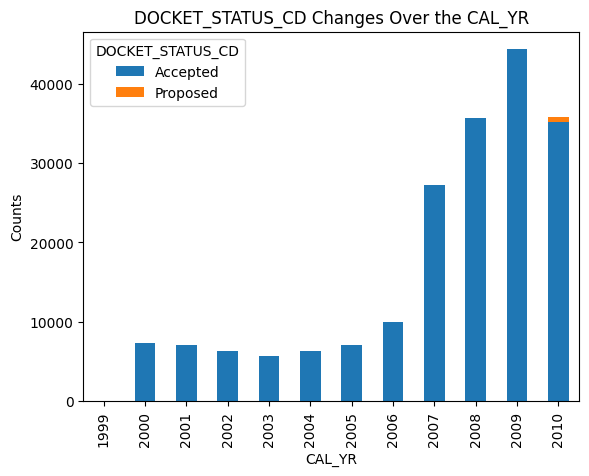

In [64]:
# Stacked bar plot of 'DOCKET_STATUS_CD' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'DOCKET_STATUS_CD' changes over the years

# Counting values grouped by CAL_YR and DOCKET_STATUS_CD
value_counts = violations.groupby('CAL_YR')['DOCKET_STATUS_CD'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('DOCKET_STATUS_CD Changes Over the CAL_YR')
plt.show()

INSIGHT: Makes sense that only the most recent data would still be in proposed status -- but no data 2011-2023?

#### Docket Status

Denotes the current status of this docket:  Approved (approved by the court) or Proposed (not yet been approved by the court).

In [65]:
# Normalized values (proportion of each value in the column) of 'CONTESTED_IND' in violations df
violations.CONTESTED_IND.value_counts(normalize = True)

CONTESTED_IND
N    0.931413
Y    0.068587
Name: proportion, dtype: float64

INSIGHT: 93% not contested.

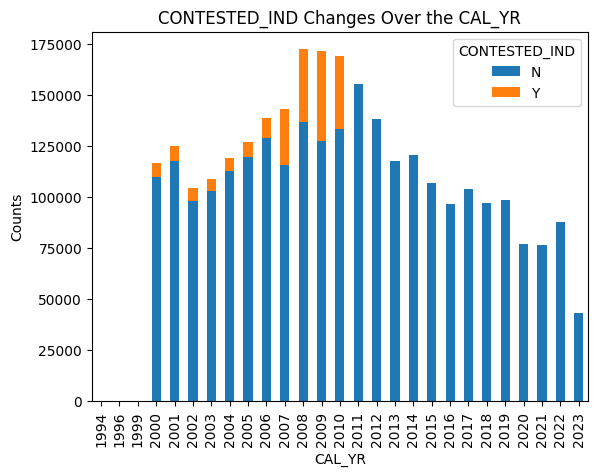

In [66]:
# Stacked bar plot of 'CONTESTED_IND' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'CONTESTED_IND' changes over the years

# Counting values goruped by CAL_YR and CONTESTED_IND
value_counts = violations.groupby('CAL_YR')['CONTESTED_IND'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('CONTESTED_IND Changes Over the CAL_YR')
plt.show()

INSIGHT: Weird that nothing has been contested since 2011? Have the rules changed for contesting?

#### Enforcement Area

Specifies the enforcement areas affected by the violating condition or practice constitute a health hazard, safety hazard, both or other type of hazard. May contain null values.

In [67]:
# Normalized values (proportion of each value in the column) of 'ENFORCEMENT_AREA' in violations df
violations.ENFORCEMENT_AREA.value_counts(normalize = True)

ENFORCEMENT_AREA
Safety             0.952724
Health             0.030129
Other              0.012258
HealthAndSafety    0.004888
Name: proportion, dtype: float64

INSIGHT: 95% are safety violations.

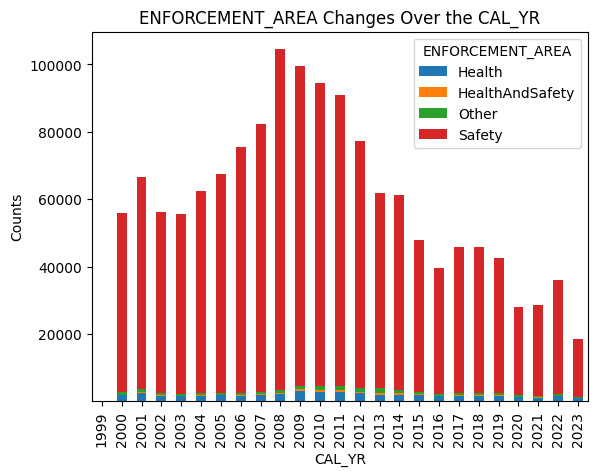

In [68]:
# Stacked bar plot of 'ENFORCEMENT_AREA' variable grouped by the 'CAL_YR' variable in violations df
# Allows us to see how 'ENFORCEMENT_AREA' changes over the years

# Counting values grouped by CAL_YR and ENFORCEMENT_AREA
value_counts = violations.groupby('CAL_YR')['ENFORCEMENT_AREA'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('ENFORCEMENT_AREA Changes Over the CAL_YR')
plt.show()

#### Controller

Name of the controller active at the time the violation was cited.  May contain null values if this record pertains to a violation issued to a contractor.

In [69]:
# Counting values of each 'CONTROLLER_NAME'
controller_valuecounts = violations['CONTROLLER_NAME'].value_counts()

# Filtering 'CONTROLLER_NAME' for controllers with 1000 or more violations
controller_valuecounts_filtered = controller_valuecounts[controller_valuecounts >= 1000]

# Viewing 'CONTROLLER_NAME' with 1000 or more violations
controller_valuecounts_filtered

CONTROLLER_NAME
CONSOL Energy Inc                  85575
Massey Energy Company              79622
Alpha Natural Resources, Inc.      66628
Alliance Resource Partners LP      62528
Robert E  Murray                   60291
                                   ...  
Wilma  Wagner                       1017
Estate of Henry T. Southway Jr.     1015
David  Stevenson                    1015
James P  Jurgensen                  1005
Fred Weber, Inc.                    1001
Name: count, Length: 300, dtype: int64

#### Section of Act

Section of the Act under which the citation/order was issued.  May contain null values.

In [70]:
# Normalized values (proportion of each value in the column) of 'SECTION_OF_ACT' in violations df
violations.SECTION_OF_ACT.value_counts(normalize = True)

SECTION_OF_ACT
316(b)              0.347556
103(h)              0.103634
103(k)              0.088409
316(b)(2)(A)        0.073058
103(d)              0.071241
109(a)              0.054637
107(a)              0.051190
109(d)              0.044549
316(b)(2)(F)(ii)    0.037030
103(a)              0.028885
104(b)              0.025815
104(g)(1)           0.013095
104(a)              0.011967
110(j)              0.008835
316(b)(2)           0.007393
103(j)              0.007018
115(a)              0.004323
104(d)(1)           0.004135
104(d)(2)           0.003697
314(b)              0.002694
316(b)(2)(C)        0.001817
203(a)              0.001692
103(f)              0.001504
109(c)              0.000877
103(a)(h)           0.000501
115(b)              0.000501
101(a)(7)           0.000439
115(e)              0.000439
105(c)              0.000439
115(a)(3)           0.000439
115(a)(2)           0.000376
317(c)              0.000376
108(a)(1)(b)        0.000188
115(a)(4)           0.000188

INSIGHT: 33% of violations are under section 316(b) - Should check out that section.

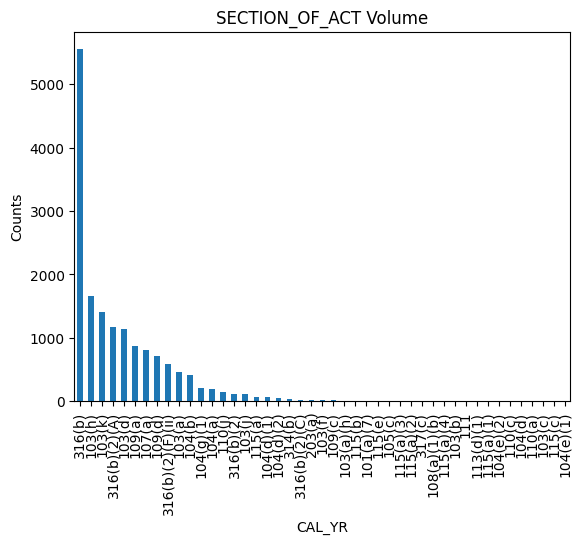

In [71]:
# Bar plot of counts of 'SECTION_OF_ACT' variable in violations df
# Allows us to see which 'SECTION_OF_ACT' is cited most in the violations df

# Counting unique values in the 'SECTION_OF_ACT' column
value_counts = violations['SECTION_OF_ACT'].value_counts()

# Creating bar plot of value counts 
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('SECTION_OF_ACT Volume')
plt.show()

#### Part Section

Code of Federal Regulations: Part/section of Title 30 CFR violated in format PPSSSSSXXXX where (P) Part, (S) Section and (X) Suffix.  Four-digit section numbers are expanded to five within one leading zero.  May contain null values.

In [72]:
# Value counts of 'PART_SECTION' in violations df
violations['PART_SECTION'].value_counts()

PART_SECTION
75.400             137985
56.14107(a)        110926
56.14100(b)         64202
56.12004            62017
75.370(a)(1)        61266
                    ...  
57.16017                1
57.4660(c)              1
56.19109                1
57.5001(a/5)(a)         1
56.4001                 1
Name: count, Length: 5829, dtype: int64

#### Section of Act 1

Primary Section of Act which gives the MSHA Inspector the authority to take the action specified by this Issuance.   More than one type of action may be cited.

In [73]:
# Value counts of 'SECTION_OF_ACT_1' in violations df
violations['SECTION_OF_ACT_1'].value_counts()

SECTION_OF_ACT_1
104(a)       2712915
104(g)(1)      23643
104(d)(1)      19159
104(b)         17660
103(k)         12915
104(d)(2)       9297
107(a)          8739
314(b)          7724
104(e)(2)        402
103(j)           254
104(e)(1)         48
104(c)             1
Name: count, dtype: int64

#### Section of Act 2

Secondary Section of Act which gives the MSHA Inspector the authority to take the action specified by this Issuance at Metal/Non-Metal mines only.  More than one type of action may be cited.

In [74]:
# Value counts of 'SECTION_OF_ACT_2' in violations df
violations['SECTION_OF_ACT_2'].value_counts()

SECTION_OF_ACT_2
104(a)       1198
104(d)(1)      10
104(d)(2)       4
104(g)(1)       3
107(a)          2
Name: count, dtype: int64

#### Initial Viol No.

This is the preceding citation record when there is a need to relate a citation to a previous one. For example this would apply when an order follows a citation. This relationship is needed to calculate the good faith reduction penalty points.  May contain null values.

In [75]:
# Value counts of 'INITIAL_VIOL_NO' in violations df
violations['INITIAL_VIOL_NO'].value_counts()

INITIAL_VIOL_NO
7126240.0    489
4182117.0    447
7096093      430
3111571.0    402
7126983.0    275
            ... 
9131397        1
9131398        1
9134296        1
9134297        1
8733426        1
Name: count, Length: 30113, dtype: int64

#### Replaced by Order No.

Order number which replaced the original citation.  May contain null values if situation does not apply.

In [76]:
# Value counts of 'REPLACED_BY_ORDER_NO' in violations df
violations['REPLACED_BY_ORDER_NO'].value_counts()

REPLACED_BY_ORDER_NO
8569821.0    2
8569825.0    2
8569824.0    2
8569823.0    2
8569822.0    2
            ..
6650590.0    1
6650600.0    1
8223480.0    1
8223481.0    1
7797678.0    1
Name: count, Length: 17237, dtype: int64

### Bivariate EDA

#### Violator Type: Number Affected

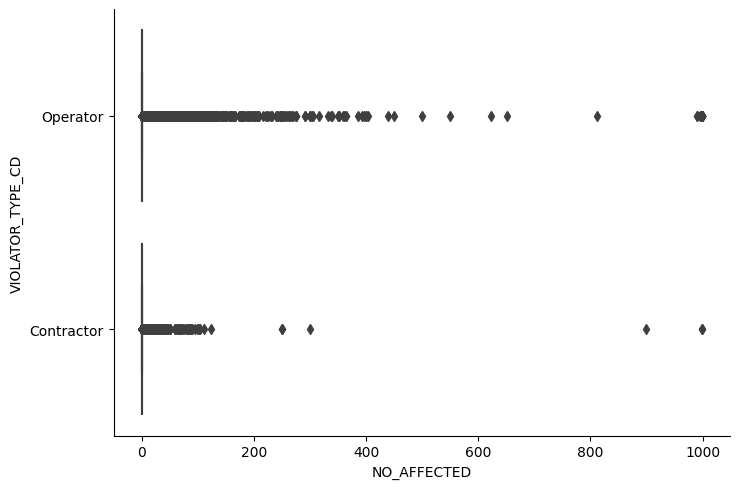

In [77]:
# Creating a catplot of 'NO_AFFECTED' by 'VIOLATOR_TYPE_CD'
# Allows us to view the distribution of 'NO_AFFECTED' across the different 'VIOLATOR_TYPE_CD' categories
sns.catplot(x="NO_AFFECTED", y="VIOLATOR_TYPE_CD", data=violations, kind="box", aspect=1.5)
plt.show()

In [78]:
# Viewing min, mean, and max of 'NO_AFFECTED' grouped by 'VIOLATOR_TYPE_CD' in violations df
violations.groupby('VIOLATOR_TYPE_CD').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

NO_AFFECTED               
                         min      mean  max
VIOLATOR_TYPE_CD                           
Contractor                 0  1.126203  999
Operator                   0  1.507789  999

INSIGHT: On average operator has more number affected, but unclear at this point if statistically significant difference (especially considering operator has way more violations).

#### Violator Type: Proposed Penalty

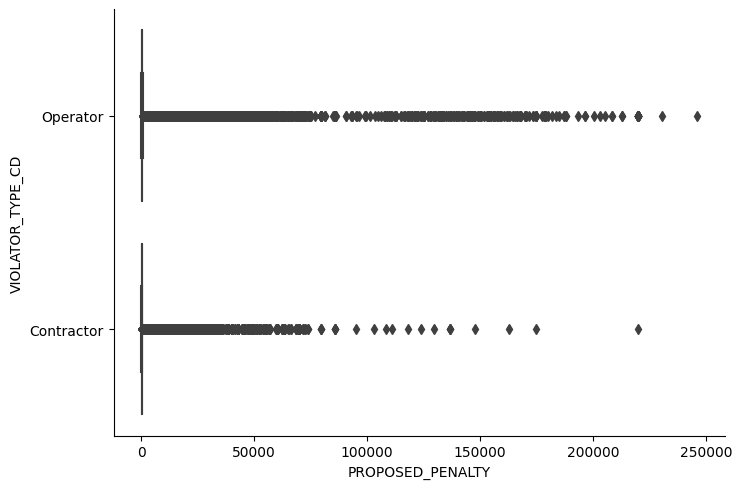

In [79]:
# Creating a catplot of 'PROPOSED_PENALTY' by 'VIOLATOR_TYPE_CD'
# Allows us to view the distribution of 'PROPOSED_PENALTY' across the different 'VIOLATOR_TYPE_CD' categories
sns.catplot(x="PROPOSED_PENALTY", y="VIOLATOR_TYPE_CD", data=violations, kind="box", aspect=1.5)
plt.show()

In [80]:
# Viewing min, mean, and max of 'PROPOSED_PENALTY' grouped by 'VIOLATOR_TYPE_CD' in violations df
violations.groupby('VIOLATOR_TYPE_CD').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

PROPOSED_PENALTY                      
                              min        mean       max
VIOLATOR_TYPE_CD                                       
Contractor                   55.0  463.414133  220000.0
Operator                      1.0  598.159052  246200.0

INSIGHT: On average operator has a higher proposed penalty, but unclear at this point if statistically significant difference (especially considering operator has way more violations).

#### Coal Metal: Mine Type

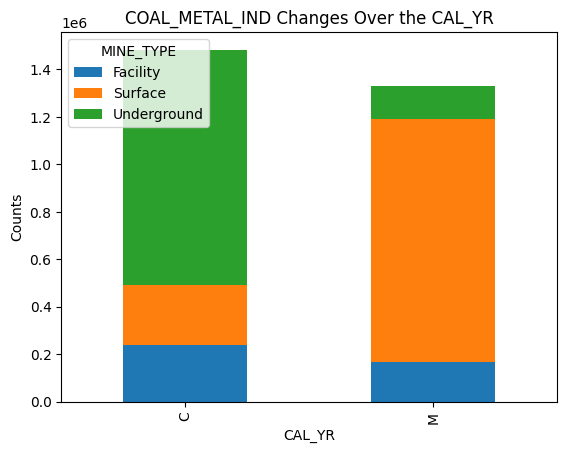

MINE_TYPE       Facility  Surface  Underground
COAL_METAL_IND                                
C                 240737   252891       989008
M                 169159  1021805       139136


In [82]:
# Getting counts of 'COAL_METAL_IND' grouped by 'MINE_TYPE' 
# Allows us to view the proportion MINE_TYPE (i.e., facility, surface, or underground)
# for 'COAL_METAL_IND'
value_counts = violations.groupby('COAL_METAL_IND')['MINE_TYPE'].value_counts().unstack()

# Creating bar plot of value counts
value_counts.plot(kind='bar', stacked=True)

plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('COAL_METAL_IND Changes Over the CAL_YR')
plt.show()

print(value_counts)

INSIGHT: The coal industry has a large majority of underground mine types (989008), whereas metal industry has a large majority of surface mine types (1021805). Both coal and metal have a relatively similar amount of facility mine types (240737 vs 169159).

#### Coal Metal: Number Affected

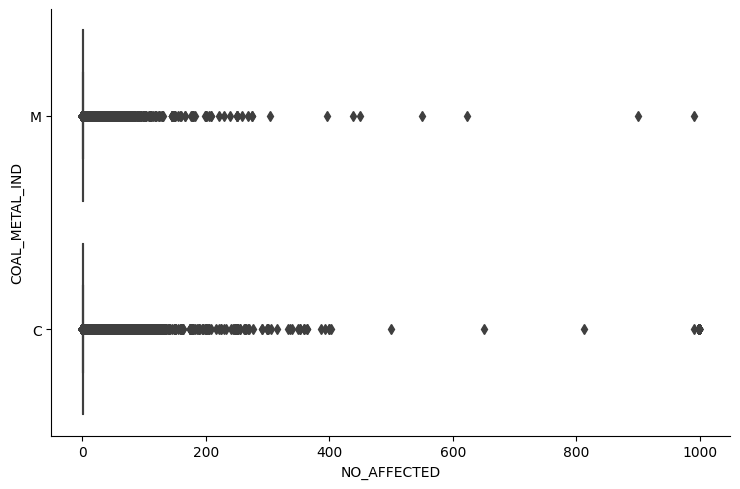

In [83]:
# Creating a catplot of 'NO_AFFECTED' by 'COAL_METAL_IND'
# Allows us to view the distribution of 'NO_AFFECTED' across the different 'COAL_METAL_IND' categories
sns.catplot(x="NO_AFFECTED", y="COAL_METAL_IND", data=violations, kind="box", aspect=1.5)
plt.show()

In [84]:
# Viewing the min, mean, and max of 'NO_AFFECTED' grouped by 'COAL_METAL_IND' in violations df
violations.groupby('COAL_METAL_IND').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

NO_AFFECTED               
                       min      mean  max
COAL_METAL_IND                           
C                        0  1.880991  999
M                        0  1.037205  991

INSIGHT: On average, coal has more affected. Seems big enough to be significant but have to see.

#### Coal Metal: Proposed Penalty

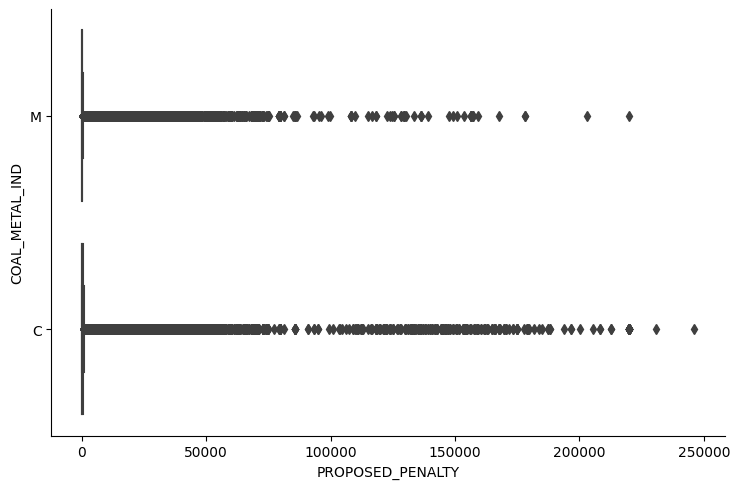

In [85]:
# Creating a catplot of 'PROPOSED_PENALTY' by 'COAL_METAL_IND'
# Allows us to view the distribution of 'PROPOSED_PENALTY' across the different 'COAL_METAL_IND' categories
sns.catplot(x="PROPOSED_PENALTY", y="COAL_METAL_IND", data=violations, kind="box", aspect=1.5)
plt.show()

In [86]:
# Viewing the min, mean, and max of 'PROPOSED_PENALTY' grouped by 'COAL_METAL_IND' in violations df
violations.groupby('COAL_METAL_IND').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

PROPOSED_PENALTY                      
                            min        mean       max
COAL_METAL_IND                                       
C                          50.0  735.276449  246200.0
M                           1.0  427.264260  220000.0

INSIGHT: On average, coal has a way higher proposed penalty ($735 vs $427)

#### Sig Sub: Number Affected

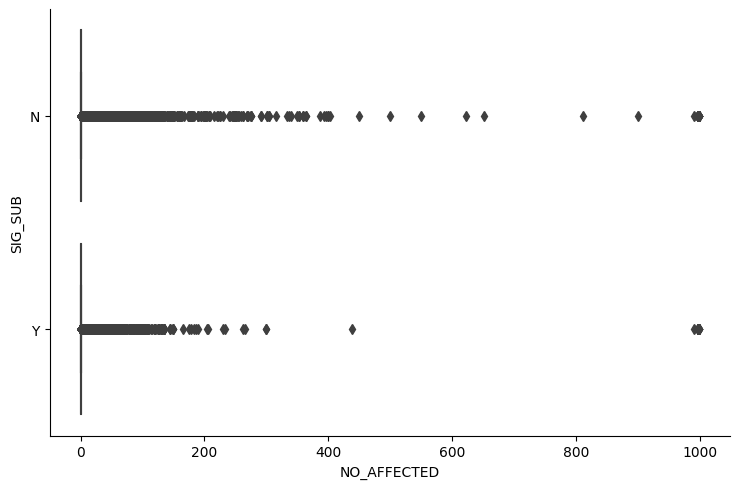

In [87]:
# Creating a catplot of 'NO_AFFECTED' by 'SIG_SUB'
# Allows us to view the distribution of 'NO_AFFECTED' across the different 'SIG_SUB' categories
sns.catplot(x="NO_AFFECTED", y="SIG_SUB", data=violations, kind="box", aspect=1.5)
plt.show()

In [88]:
# Viewing the min, mean, and max of 'NO_AFFECTED' grouped by 'SIG_SUB' in violations df
violations.groupby('SIG_SUB').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

NO_AFFECTED               
                min      mean  max
SIG_SUB                           
N                 0  1.474118  999
Y                 0  1.589535  999

INSIGHT: Definitely expected to see a bigger difference here! Indicates room for improvement in designation of significant/substancial violation.

#### Sig Sub: Proposed Penalty

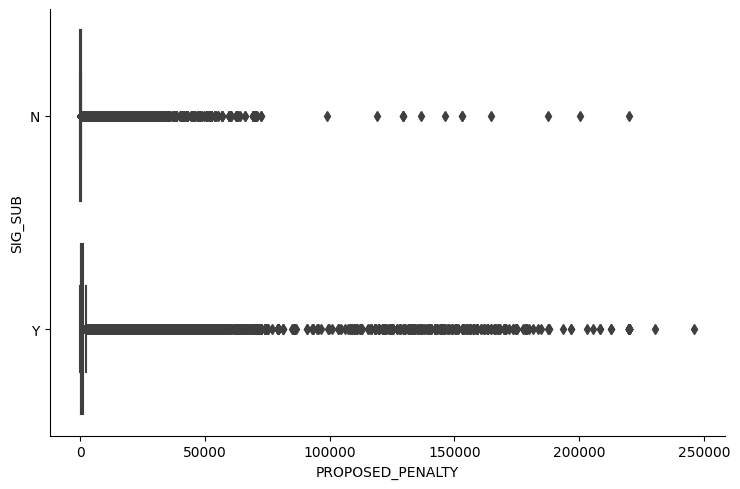

In [89]:
# Creating a catplot of 'PROPOSED_PENALTY' by 'SIG_SUB'
# Allows us to view the distribution of 'PROPOSED_PENALTY' across the different 'SIG_SUB' categories
sns.catplot(x="PROPOSED_PENALTY", y="SIG_SUB", data=violations, kind="box", aspect=1.5)
plt.show()

In [90]:
# Viewing the min, mean, and max of 'PROPOSED_PENALTY' grouped by 'SIG_SUB' in violations df
violations.groupby('SIG_SUB').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

PROPOSED_PENALTY                       
                     min         mean       max
SIG_SUB                                        
N                   50.0   250.786067  220000.0
Y                    1.0  1472.845271  246200.0

INSIGHT: Now here is a big difference!

#### Section of Act: Number Affected

In [91]:
# Viewing the min, mean, and max of 'NO_AFFECTED' grouped by 'SECTION_OF_ACT' in violations df
violations.groupby('SECTION_OF_ACT').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

NO_AFFECTED                
                         min       mean  max
SECTION_OF_ACT                              
101(a)(7)                  0   2.714286   10
103(a)                     0   2.264642  118
103(a)(h)                  0   0.125000    1
103(b)                     0   0.000000    0
103(c)                     1   1.000000    1
103(d)                     0   0.194371    2
103(f)                     0   7.333333  160
103(h)                     0   0.154776    7
103(j)                     0   0.687500   25
103(k)                     0   0.184266   24
104(a)                     0   1.554974   70
104(b)                     0   3.189320  998
104(d)                     1   1.000000    1
104(d)(1)                  0   2.393939   10
104(d)(2)                  0   1.915254   15
104(e)(1)                  0   0.000000    0
104(e)(2)                  1   2.500000    4
104(g)(1)                  0   2.425837   32
105(c)                     0   0.571429    1
107(a)                     0   0.062424    7
108(a)(1)(b)               1   1.000000    1
109(a)                     0   3.402523  393
109(c)                     0   0.214286    1
109(d)                     0   0.488045  101
110(a)                     2   2.000000    2
110(c)                     3   3.000000    3
110(j)                     0   4.425532  132
111                       56  58.500000   61
113(d)(1)                  1   1.000000    1
115(a)                     0   2.000000    6
115(a)(1)                  2   2.000000    2
115(a)(2)                  1   1.500000    3
115(a)(3)                  1   3.285714    7
115(a)(4)                  0   0.666667    1
115(b)                     0   3.375000   13
115(c)                     0   0.000000    0
115(e)                     0   3.571429   10
203(a)                     0  15.703704  180
314(b)                     0   2.418605   14
316(b)                     0   5.955111  110
316(b)(2)                  0   3.313559   36
316(b)(2)(A)               0   4.596055  183
316(b)(2)(C)               0   4.241379   17
316(b)(2)(F)(ii)           0   4.910321   40
317(c)                     1   2.666667   11

INSIGHT: Section of act 11, on average affects the largest number of people (59 people).

#### Section of Act: Proposed Penalty

In [92]:
# Viewing min, mean, and max of 'PROPOSED_PENALTY' goruped by 'SECTION_OF_ACT' in violations df
violations.groupby('SECTION_OF_ACT').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

PROPOSED_PENALTY                         
                              min           mean       max
SECTION_OF_ACT                                            
101(a)(7)                   100.0     117.714286     224.0
103(a)                       55.0    1664.790055  220000.0
103(a)(h)                    55.0    1682.800000    8000.0
103(b)                       55.0      85.000000     100.0
103(c)                       55.0      55.000000      55.0
103(d)                       55.0      65.987421     760.0
103(f)                       55.0     838.045455    5000.0
103(h)                       55.0      77.394622    2000.0
103(j)                       55.0     409.714286   10000.0
103(k)                       55.0    1804.173913   14700.0
104(a)                       55.0     366.651934   25000.0
104(b)                       55.0    1335.601449   52000.0
104(d)                     3500.0    3500.000000    3500.0
104(d)(1)                   112.0    5545.272727   70800.0
104(d)(2)                    55.0    5011.172414   35500.0
104(e)(1)                   129.0     129.000000     129.0
104(e)(2)                   154.0     264.000000     374.0
104(g)(1)                    55.0     693.931034   15700.0
105(c)                      116.0     470.400000    1264.0
107(a)                       55.0    2527.942857   25000.0
108(a)(1)(b)                 55.0      71.666667     100.0
109(a)                       55.0     100.408879     687.0
109(c)                       60.0      99.642857     121.0
109(d)                       55.0      70.882521    1247.0
110(a)                   138500.0  138500.000000  138500.0
110(c)                      116.0     116.000000     116.0
110(j)                      100.0     231.061224    1052.0
111                         100.0     125.000000     150.0
113(d)(1)                   116.0     144.500000     173.0
115(a)                       55.0     109.088235    1815.0
115(a)(1)                    79.0     175.000000     271.0
115(a)(2)                    55.0     413.333333    1000.0
115(a)(3)                   122.0     430.857143    1186.0
115(a)(4)                    55.0    1790.666667    5000.0
115(b)                       55.0      98.375000     135.0
115(c)                       55.0      55.000000      55.0
115(e)                       55.0     117.142857     293.0
203(a)                       55.0     381.740741    6996.0
314(b)                      121.0     745.657895    6725.0
316(b)                       60.0    1240.995615   72620.0
316(b)(2)                    60.0     719.855856    4353.0
316(b)(2)(A)                100.0    1825.764757  230600.0
316(b)(2)(C)                100.0     965.689655    6624.0
316(b)(2)(F)(ii)            100.0    1027.766839   56900.0
317(c)                      104.0    1052.000000    2000.0

INSIGHT: Section of act 110(a) has the largest average proposed penalty at $138,500. Interesting that the section does not match for average proposed penalty and average no_affected.

#### Likelihood: Number Affected

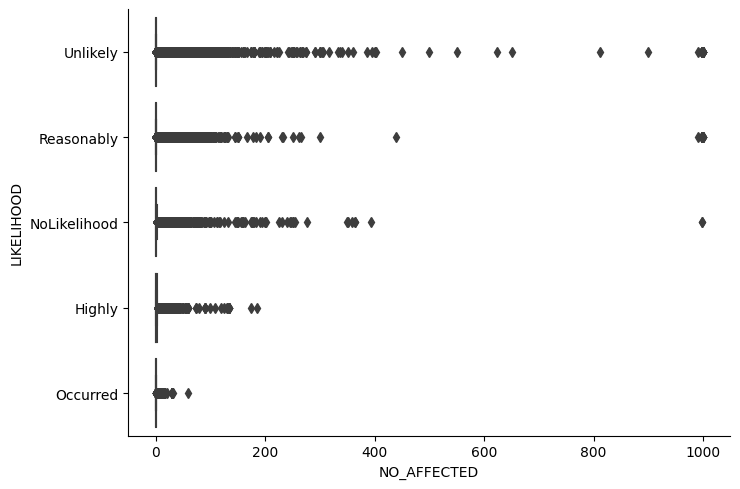

In [93]:
# Creating a catplot of 'NO_AFFECTED' by 'LIKELIHOOD'
# Allows us to view the distribution of 'NO_AFFECTED' across the different 'LIKELIHOOD' categories
sns.catplot(x="NO_AFFECTED", y="LIKELIHOOD", data=violations, kind="box", aspect=1.5)
plt.show()

In [94]:
# Viewing min, mean, and max of 'NO_AFFECTED' grouped by 'LIKELIHOOD' in violations df
violations.groupby('LIKELIHOOD').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

NO_AFFECTED               
                     min      mean  max
LIKELIHOOD                             
Highly                 0  2.487306  186
NoLikelihood           0  0.669542  998
Occurred               0  1.343720   60
Reasonably             0  1.579924  999
Unlikely               0  1.535572  999

INSIGHT: Highly likely things impact more people on average.

#### Likelihood: Proposed Penalty

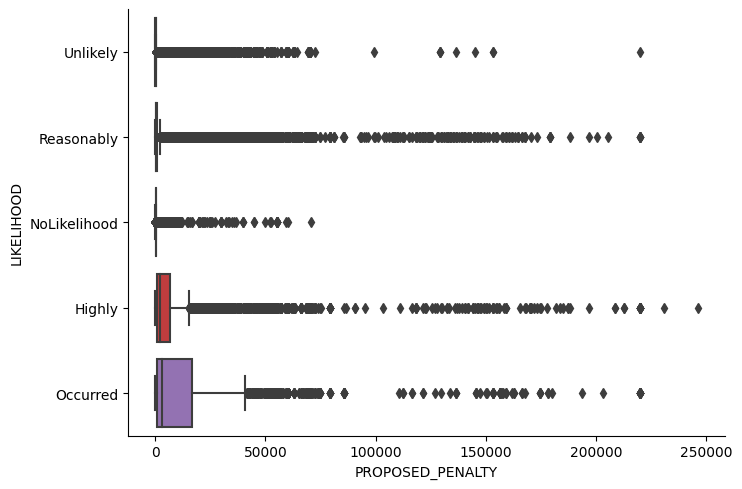

In [95]:
# Creating a catplot of 'PROPOSED_PENALTY' by 'LIKELIHOOD'
# Allows us to view the distribution of 'PROPOSED_PENALTY' across the different 'LIKELIHOOD' categories
sns.catplot(x="PROPOSED_PENALTY", y="LIKELIHOOD", data=violations, kind="box", aspect=1.5)
plt.show()

In [96]:
# Viewing min, mean, and max of 'PROPOSED_PEANLTY' grouped by 'LIKELIHOOD' in violations df
violations.groupby('LIKELIHOOD').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

PROPOSED_PENALTY                        
                          min          mean       max
LIKELIHOOD                                           
Highly                   55.0   8615.221286  246200.0
NoLikelihood             55.0    153.165868   70800.0
Occurred                 55.0  15427.745790  220000.0
Reasonably               50.0   1217.201960  220000.0
Unlikely                 50.0    253.964209  220000.0

#### Injury Illness: Number Affected

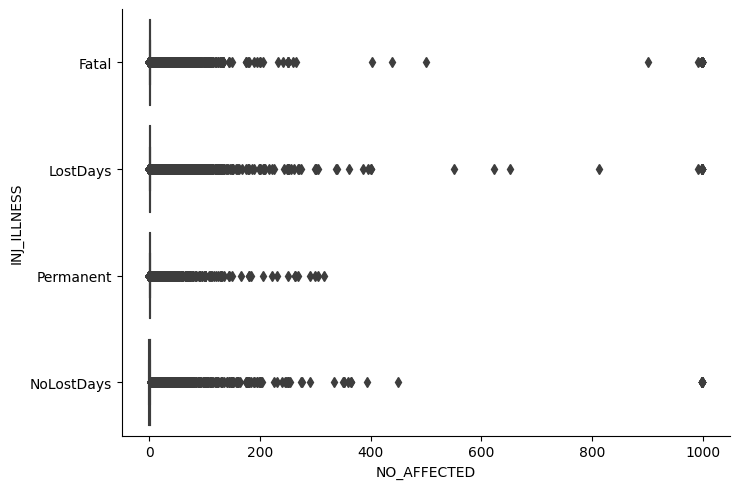

In [97]:
# Creating a catplot of 'NO_AFFECTED' by 'INJ_ILLNESS'
# Allows us to view the distribution of 'NO_AFFECTED' across the different 'INJ_ILLNESS' categories
sns.catplot(x="NO_AFFECTED", y="INJ_ILLNESS", data=violations, kind="box", aspect=1.5)
plt.show()

In [98]:
# Viewing min, mean, and max of 'NO_AFFECTED' grouped by 'INJ_ILLNESS' in violations df
violations.groupby('INJ_ILLNESS').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

NO_AFFECTED               
                    min      mean  max
INJ_ILLNESS                           
Fatal                 0  1.609549  999
LostDays              0  1.565061  999
NoLostDays            0  1.226696  999
Permanent             0  1.384891  316

#### Injury Illness: Proposed Penalty

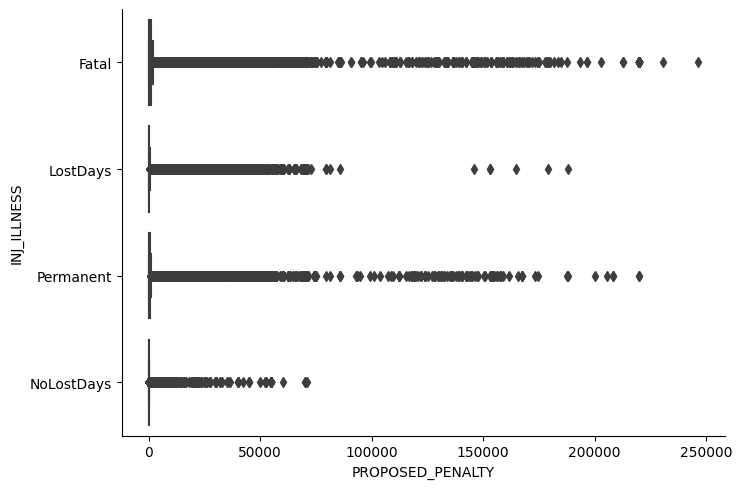

In [99]:
# Creating a catplot of 'PROPOSED_PENALTY' by 'INJ_ILLNESS'
# Allows us to view the distribution of 'PROPOSED_PENALTY' across the different 'INJ_ILLNESS' categories
sns.catplot(x="PROPOSED_PENALTY", y="INJ_ILLNESS", data=violations, kind="box", aspect=1.5)
plt.show()

In [100]:
# Viewing min, mean, and max of 'PROPOSED_PENALTY' grouped by 'INJ_ILLNESS' in violations df
violations.groupby('INJ_ILLNESS').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

PROPOSED_PENALTY                       
                         min         mean       max
INJ_ILLNESS                                        
Fatal                   50.0  1359.180262  246200.0
LostDays                50.0   392.324805  188000.0
NoLostDays              55.0   138.178369   70800.0
Permanent               50.0   765.378365  220000.0

INSIGHT: The worse the injury/impact, the higher the penalty.

#### Negligence: Number Affected

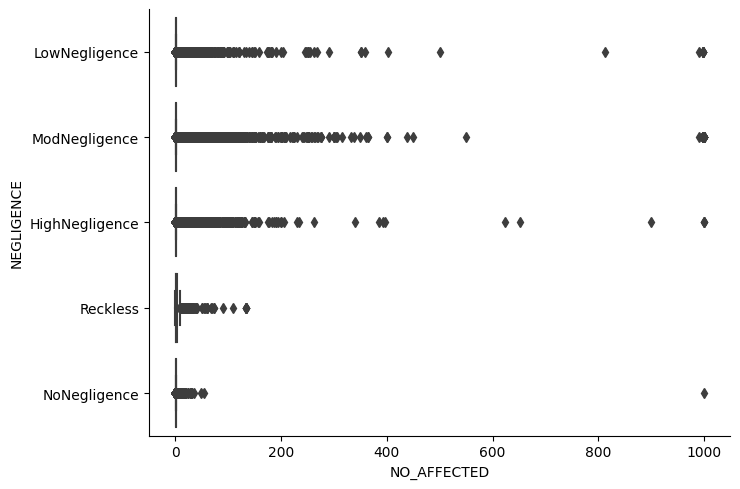

In [101]:
# Creating a catplot of 'NO_AFFECTED' by 'NEGLIGENCE'
# Allows us to view the distribution of 'NO_AFFECTED' across the different 'NEGLIGENCE' categories
sns.catplot(x="NO_AFFECTED", y="NEGLIGENCE", data=violations, kind="box", aspect=1.5)
plt.show()

In [102]:
# Viewing the min, mean, and max of 'NO_AFFECTED' grouped by 'NEGLIGENCE' in violations df
violations.groupby('NEGLIGENCE').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

NO_AFFECTED               
                       min      mean  max
NEGLIGENCE                               
HighNegligence           0  1.878352  999
LowNegligence            0  1.370407  998
ModNegligence            0  1.499221  999
NoNegligence             0  1.807981  999
Reckless                 0  4.368368  134

INSIGHT: Reckless violations affect more people on average.

#### Negligence: Proposed Penalty

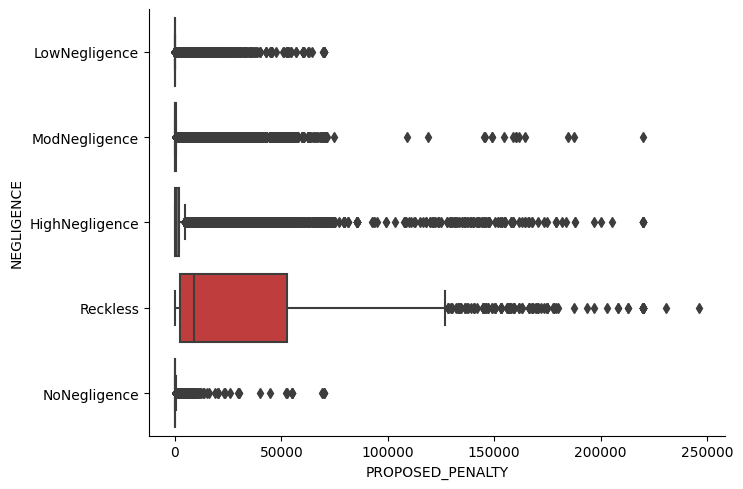

In [103]:
# Creating a catplot of 'PROPOSED_PENALTY' by 'NEGLIGENCE'
# Allows us to view the distribution of 'PROPOSED_PENALTY' across the different 'NEGLIGENCE' categories
sns.catplot(x="PROPOSED_PENALTY", y="NEGLIGENCE", data=violations, kind="box", aspect=1.5)
plt.show()

In [104]:
# Viewing min, mean, and max of 'PROPOSED_PENALTY' grouped by 'NEGLIGENCE' in violations df
violations.groupby('NEGLIGENCE').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

PROPOSED_PENALTY                        
                            min          mean       max
NEGLIGENCE                                             
HighNegligence             55.0   2970.551688  220000.0
LowNegligence              55.0    289.351414   70000.0
ModNegligence              50.0    423.038766  220000.0
NoNegligence               55.0    682.605893   70000.0
Reckless                   55.0  32007.431113  246200.0

INSIGHT: Reckless and highly negligent actions carry higher penalties.

#### Enforcement Area: Number Affected

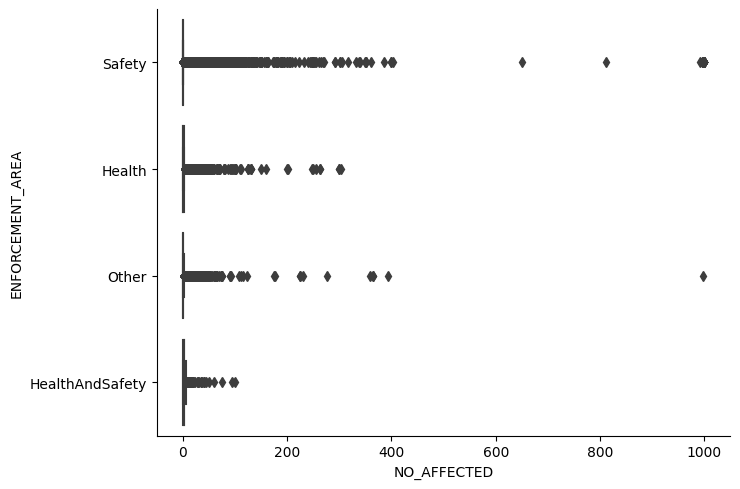

In [105]:
# Creating a catplot of 'NO_AFFECTED' by 'ENFORCEMENT_AREA'
# Allows us to view the distribution of 'NO_AFFECTED' across the different 'ENFORCEMENT_AREA' categories
sns.catplot(x="NO_AFFECTED", y="ENFORCEMENT_AREA", data=violations, kind="box", aspect=1.5)
plt.show()

In [106]:
# Viewing min, mean, and max of 'NO_AFFECTED' grouped by 'ENFORCEMENT_AREA' in violations df
violations.groupby('ENFORCEMENT_AREA').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

NO_AFFECTED               
                         min      mean  max
ENFORCEMENT_AREA                           
Health                     0  2.295928  304
HealthAndSafety            0  2.725637  100
Other                      0  1.425779  998
Safety                     0  1.904588  999

#### Enforcement Area: Proposed Penalty

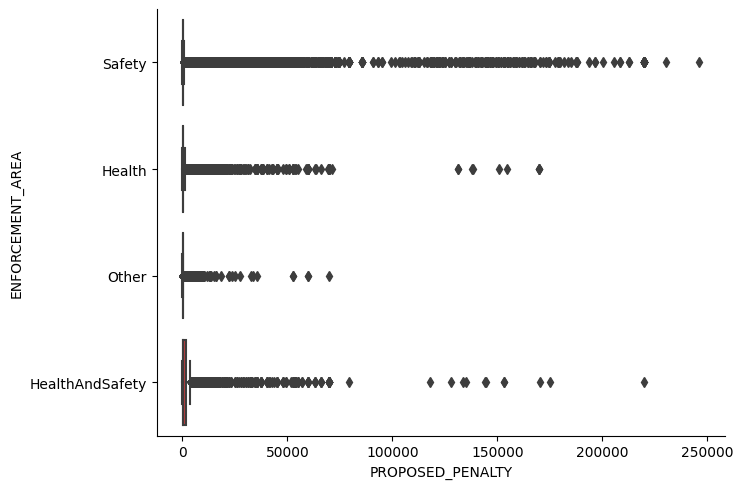

In [107]:
# Creating a catplot of 'PROPOSED_PENALTY' by 'ENFORCEMENT_AREA'
# Allows us to view the distribution of 'PROPOSED_PENALTY' across the different 'ENFORCEMENT_AREA' categories
sns.catplot(x="PROPOSED_PENALTY", y="ENFORCEMENT_AREA", data=violations, kind="box", aspect=1.5)
plt.show()

In [108]:
# Viewing min, mean, and max of 'PROPOSED_PENALTY' grouped by 'ENFORCEMENT_AREA' in violations df
violations.groupby('ENFORCEMENT_AREA').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

PROPOSED_PENALTY                       
                              min         mean       max
ENFORCEMENT_AREA                                        
Health                       50.0   698.758709  169800.0
HealthAndSafety              55.0  2256.366657  220000.0
Other                        55.0   227.678915   70000.0
Safety                       55.0   738.672898  246200.0

INSIGHT: Health AND safety violations carry high penalties -- makes sense, they're double whammies!

#### Contested: Number Affected

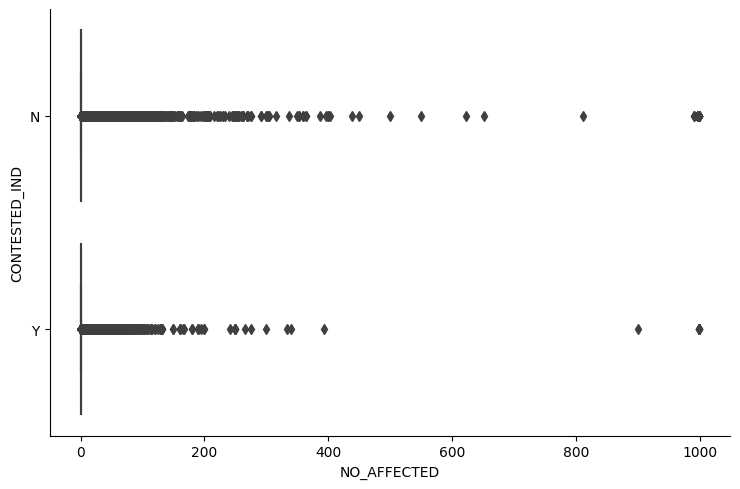

In [109]:
# Creating a catplot of 'NO_AFFECTED' by 'CONTESTED_IND'
# Allows us to view the distribution of 'NO_AFFECTED' across the different 'CONTESTED_IND' categories
sns.catplot(x="NO_AFFECTED", y="CONTESTED_IND", data=violations, kind="box", aspect=1.5)
plt.show()

In [110]:
# Viewing min, mean, and max of 'NO_AFFECTED' grouped by 'CONTESTED_IND' in violations df
violations.groupby('CONTESTED_IND').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

NO_AFFECTED               
                      min      mean  max
CONTESTED_IND                           
N                       0  1.426457  999
Y                       0  2.235907  999

INSIGHT: Interesting -- I wouldn't have that that contested violations would have affected more people on average!

#### Contested: Proposed Penalty

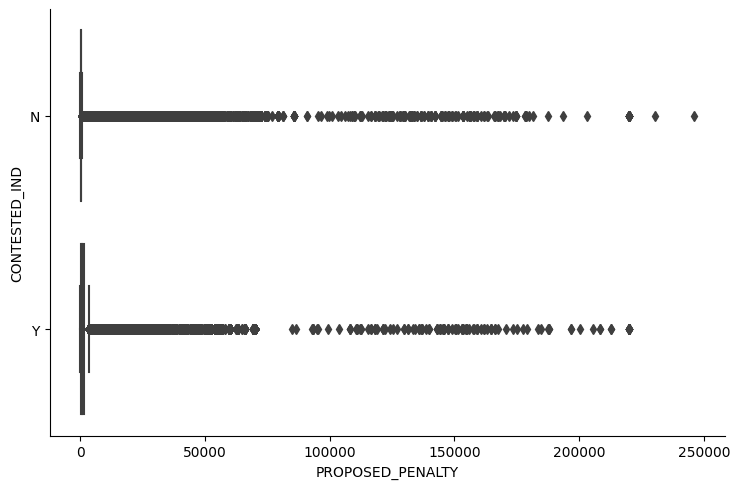

In [111]:
# Creating a catplot of 'PROPOSED_PENALTY' by 'CONTESTED_IND'
# Allows us to view the distribution of 'PROPOSED_PENALTY' across the different 'CONTESTED_IND' categories
sns.catplot(x="PROPOSED_PENALTY", y="CONTESTED_IND", data=violations, kind="box", aspect=1.5)
plt.show()

In [112]:
# Viewing min, mean, and max of 'PROPOSED_PENALTY' grouped by 'CONTESTED_IND' in violations df
violations.groupby('CONTESTED_IND').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

PROPOSED_PENALTY                       
                           min         mean       max
CONTESTED_IND                                        
N                         50.0   484.634852  246200.0
Y                          1.0  1973.085424  220000.0

INSIGHT: Interesting -- People contest higher proposed violations!

## Accidents Dataset

### Viewing the Accidents Dataset

In [113]:
# Viewing first few rows of accidents df
accidents.head()

,MINE_ID,CONTROLLER_ID,CONTROLLER_NAME,OPERATOR_ID,OPERATOR_NAME,CONTRACTOR_ID,DOCUMENT_NO,SUBUNIT_CD,SUBUNIT,ACCIDENT_DT,...,DAYS_RESTRICT,DAYS_LOST,TRANS_TERM,RETURN_TO_WORK_DT,IMMED_NOTIFY_CD,IMMED_NOTIFY,INVEST_BEGIN_DT,NARRATIVE,CLOSED_DOC_NO,COAL_METAL_IND
0,100003,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",MPH,220132310045,3,"STRIP, QUARY, OPEN PIT",08/12/2013,...,2.0,0,N,08/19/2013,?,NO VALUE FOUND,NaN,Employee says he slipped off back of fuel truc...,NaN,M
1,100003,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",NaN,220230030038,30,MILL OPERATION/PREPARATION PLANT,12/24/2022,...,NaN,NaN,NaN,NaN,?,NO VALUE FOUND,NaN,EE was carrying 5-gallon fuel cans up top the ...,NaN,M
2,100009,M00024,Legacy Vulcan Corp (Form:Vulcan Materials Co),L16168,"Vulcan Construction Materials, LLC",NaN,220053250019,3,"STRIP, QUARY, OPEN PIT",11/13/2005,...,13.0,0,N,12/01/2005,?,NO VALUE FOUND,NaN,2 employees were attempting to load troughing ...,320053360009,M
3,100011,M11763,Imerys S A,L17074,Imerys Pigments LLC,NaN,220062000052,30,MILL OPERATION/PREPARATION PLANT,07/14/2006,...,0.0,0,N,07/15/2006,?,NO VALUE FOUND,NaN,Employee was pushing against pry bar. Bar slip...,NaN,M
4,100011,M11763,Imerys S A,0090005,Imerys Carbonates LLC,NaN,220090120006,30,MILL OPERATION/PREPARATION PLANT,01/08/2009,...,0.0,0,N,01/09/2009,?,NO VALUE FOUND,NaN,Employee tripped on c-channel at #6 silo. Fel...,NaN,M


In [117]:
# Printing the sum of missing values in accidents df

# Setting max number of rows to display; view all rows
pd.set_option('display.max_rows', None)

# Summation of missing values 
missing_sum = accidents.isna().sum()

# Printing missing values that are greater than 0
print(missing_sum[missing_sum > 0]) # nulls

pd.reset_option('display.max_rows')

CONTROLLER_ID           719
CONTROLLER_NAME         719
OPERATOR_ID             719
OPERATOR_NAME           719
CONTRACTOR_ID        229611
ACCIDENT_TIME             1
EQUIP_MODEL_NO       151664
SHIFT_BEGIN_TIME        990
NO_INJURIES              24
TOT_EXPER             42602
MINE_EXPER            39673
JOB_EXPER             38873
INJ_BODY_PART            25
SCHEDULE_CHARGE       65023
DAYS_RESTRICT         59928
DAYS_LOST             44754
TRANS_TERM            34368
RETURN_TO_WORK_DT     41033
IMMED_NOTIFY             82
INVEST_BEGIN_DT      203054
NARRATIVE                91
CLOSED_DOC_NO        143124
COAL_METAL_IND          134
dtype: int64


### Accident Distribution Overtime

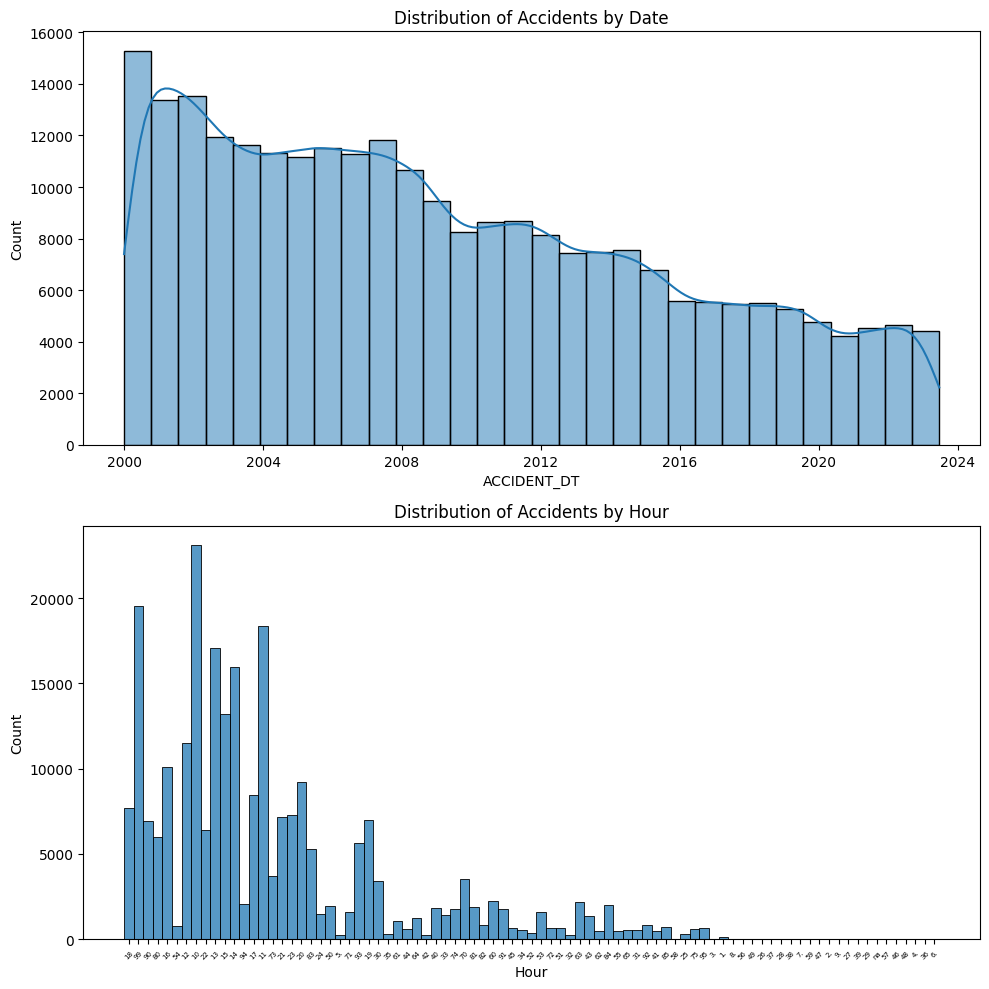

In [115]:
# Subseting accidents 
accidents_df = accidents[['MINE_ID', 'CONTROLLER_ID','ACCIDENT_DT','ACCIDENT_TYPE', 'ACCIDENT_TIME', 'NO_INJURIES','NARRATIVE']]

warnings.filterwarnings("ignore")

with warnings.catch_warnings():
    # Convert 'ACCIDENT_DT' to datetime format
    # ** If I use the format that the warning is suggesting then the dtype does not change --> accidents_df.loc[:,'ACCIDENT_DT'] = 
    accidents_df['ACCIDENT_DT'] = pd.to_datetime(accidents_df['ACCIDENT_DT'], format='%m/%d/%Y')

    # Extract month and year from 'ACCIDENT_DT'
    accidents_df.loc[:, 'Month'] = accidents_df['ACCIDENT_DT'].dt.month
    accidents_df.loc[:, 'Year'] = accidents_df['ACCIDENT_DT'].dt.year

    # Convert 'ACCIDENT_TIME' to string format and extract hour and minute
    accidents_df.loc[:, 'ACCIDENT_TIME'] = accidents_df['ACCIDENT_TIME'].astype(str)
    accidents_df.loc[:, 'Hour'] = accidents_df['ACCIDENT_TIME'].str[:2]
    accidents_df.loc[:, 'Minute'] = accidents_df['ACCIDENT_TIME'].str[2:]

# Perform EDA on 'ACCIDENT_DT' and 'ACCIDENT_TIME'
plt.figure(figsize=(10, 10))

# EDA for 'ACCIDENT_DT'
plt.subplot(2, 1, 1)
sns.histplot(data=accidents_df, x='ACCIDENT_DT', bins=30, kde=True)
plt.title('Distribution of Accidents by Date')

# EDA for 'ACCIDENT_TIME'
plt.subplot(2, 1, 2)
sns.histplot(data=accidents_df, x='Hour', bins=24)
plt.title('Distribution of Accidents by Hour')
plt.xticks(rotation=45, fontsize=5)

plt.tight_layout()

plt.show()

In [ ]:
# Want to be able to comment each out to drop columns 
# accidents_df = accidents[[
# 'MINE_ID',
# 'CONTROLLER_ID',
# 'CONTROLLER_NAME',
# 'OPERATOR_ID',
# 'OPERATOR_NAME',
# 'CONTRACTOR_ID',
# 'DOCUMENT_NO',
# 'SUBUNIT_CD',
# 'SUBUNIT',
# 'ACCIDENT_DT',
# 'CAL_YR',
# 'CAL_QTR',
# 'FISCAL_YR',
# 'FISCAL_QTR',
# 'ACCIDENT_TIME',
# 'DEGREE_INJURY_CD',
# 'DEGREE_INJURY',
# 'FIPS_STATE_CD',
#'UG_LOCATION_CD',
#'UG_LOCATION',
#'UG_MINING_METHOD_CD',
#'UG_MINING_METHOD',
# 'MINING_EQUIP_CD',
# 'MINING_EQUIP',
# 'EQUIP_MFR_CD',
# 'EQUIP_MFR_NAME',
# 'EQUIP_MODEL_NO',
#'SHIFT_BEGIN_TIME',
# 'CLASSIFICATION_CD',
# 'CLASSIFICATION',
# 'ACCIDENT_TYPE_CD',
# 'ACCIDENT_TYPE',
# 'NO_INJURIES',
#'TOT_EXPER',
#'MINE_EXPER',
#'JOB_EXPER',
# 'OCCUPATION_CD',
# 'OCCUPATION',
# 'ACTIVITY_CD',
# 'ACTIVITY',
# 'INJURY_SOURCE_CD',
# 'INJURY_SOURCE',
# 'NATURE_INJURY_CD',
# 'NATURE_INJURY',
# 'INJ_BODY_PART_CD',
# 'INJ_BODY_PART',
# 'SCHEDULE_CHARGE',
# 'DAYS_RESTRICT',
# 'DAYS_LOST',
# 'TRANS_TERM',
# 'RETURN_TO_WORK_DT',
# 'IMMED_NOTIFY_CD',
# 'IMMED_NOTIFY',
# 'INVEST_BEGIN_DT',
# 'NARRATIVE',
#'CLOSED_DOC_NO',
#'COAL_METAL_IND'
# ]]

# Data Cleaning

## Assessing Duplicates

In [119]:
violations.duplicated().sum()

0

In [120]:
accidents.duplicated().sum()

0

INSIGHT: No duplicate values in the violations and accidents dataframes.

## Assessing Nulls

### Violation Data

In [4]:
# assessing null values in the df
pd.set_option('display.max_rows', None)

missing_sum = violations.isna().sum()
print(missing_sum[missing_sum > 0])

pd.reset_option('display.max_rows')

INSPECTION_END_DT                 7665
CONTROLLER_ID                   192131
CONTROLLER_NAME                 192131
VIOLATOR_ID                        120
VIOLATOR_NAME                      135
MINE_TYPE                           21
CONTRACTOR_ID                  2622477
SIG_SUB                          45093
SECTION_OF_ACT                 2796797
PART_SECTION                     30731
SECTION_OF_ACT_2               2811540
ORIG_TERM_DUE_DT                677782
ORIG_TERM_DUE_TIME              677782
LATEST_TERM_DUE_DT               94312
LATEST_TERM_DUE_TIME             94312
TERMINATION_DT                   18626
TERMINATION_TIME                 18626
VACATE_DT                      2812687
VACATE_TIME                    2812687
INITIAL_VIOL_NO                2737136
REPLACED_BY_ORDER_NO           2795513
LIKELIHOOD                       46331
INJ_ILLNESS                      46314
NEGLIGENCE                       46297
WRITTEN_NOTICE                 1440981
ENFORCEMENT_AREA         

In [5]:
# Fill in missing values
violations  = violations.replace('?', np.nan)

### Accident Data

In [6]:
# assessing null values in the df
pd.set_option('display.max_rows', None)

missing_sum = accidents.isna().sum()
print(missing_sum[missing_sum > 0])

pd.reset_option('display.max_rows')

CONTROLLER_ID           719
CONTROLLER_NAME         719
OPERATOR_ID             719
OPERATOR_NAME           719
CONTRACTOR_ID        229611
ACCIDENT_TIME             1
EQUIP_MODEL_NO       151664
SHIFT_BEGIN_TIME        990
NO_INJURIES              24
TOT_EXPER             42602
MINE_EXPER            39673
JOB_EXPER             38873
INJ_BODY_PART            25
SCHEDULE_CHARGE       65023
DAYS_RESTRICT         59928
DAYS_LOST             44754
TRANS_TERM            34368
RETURN_TO_WORK_DT     41033
IMMED_NOTIFY             82
INVEST_BEGIN_DT      203054
NARRATIVE                91
CLOSED_DOC_NO        143124
COAL_METAL_IND          134
dtype: int64


In [7]:
# Fill in missing values
accidents  = accidents.replace('?', np.nan)

## Addressing Nulls

### INSPECTION_END_DT Missing Values: Remove INSPECTION_START_DT with year 2023

/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/1807657532.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_end_dt['INSPECTION_BEGIN_DT'] = pd.to_datetime(missing_end_dt['INSPECTION_BEGIN_DT'])
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/1807657532.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_end_dt['Year'] = missing_end_dt['INSPECTION_BEGIN_DT'].dt.year


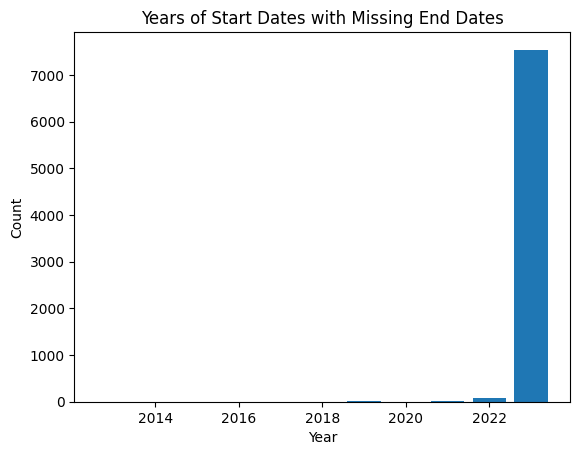

Year
2013       2
2014       1
2015       1
2018       2
2019       9
2020       3
2021      19
2022      86
2023    7542
Name: count, dtype: int64


In [28]:
# Visualizing the missing INSPECTION_END_DT's by year to test theory that majority of missings
# are coming from 2023 because inspection is still ongoing
missing_end_dt = violations[violations['INSPECTION_END_DT'].isnull()]

missing_end_dt['INSPECTION_BEGIN_DT'] = pd.to_datetime(missing_end_dt['INSPECTION_BEGIN_DT'])
missing_end_dt['Year'] = missing_end_dt['INSPECTION_BEGIN_DT'].dt.year
counts_by_year = missing_end_dt['Year'].value_counts().sort_index()

plt.bar(counts_by_year.index, counts_by_year.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Years of Start Dates with Missing End Dates')
plt.show()

print(counts_by_year)

Insight: We can see that majority of the inspections with missing end dates are inspections that started in 2023, which makes sense, given that those inspections are likely still ongoing. Would make sense to remove year 2023 of INSPECTION_BEGIN_DT from dataframe. We can also see in counts_by_year that there are some missing end dates for some pretty early years (i.e., 2013, 2014, 2015). Inspection may have been terminated or for some other reason the inspection was never completed, so would make sense to remove these as well.

In [29]:
# Copying dataframe for cleaned data
violations_cleaned = violations.copy()

# Converting 'INSPECTION_BEGIN_DT' to a datetime column 
violations_cleaned['INSPECTION_BEGIN_DT'] = pd.to_datetime(violations_cleaned['INSPECTION_BEGIN_DT'])

# Removing year 2023 from 'INSPECTION_LENGTH_DAYS' in violations df
violations_cleaned = violations_cleaned[violations_cleaned['INSPECTION_BEGIN_DT'].dt.year != 2023]

In [30]:
# confirming removal of 2023 from 'INSPECTION_BEGIN_DT' column
violations_cleaned['Year'] = violations_cleaned['INSPECTION_BEGIN_DT'].dt.year
violations_cleaned['Year'].value_counts().sort_index()

Year
2000    119520
2001    124165
2002    104371
2003    108413
2004    119971
2005    126672
2006    139122
2007    142686
2008    171914
2009    172486
2010    168977
2011    154499
2012    137519
2013    117695
2014    120269
2015    106260
2016     96407
2017    103712
2018     97202
2019     98521
2020     76781
2021     77177
2022     87185
Name: count, dtype: int64

In [31]:
# Dropping created year column 
violations_cleaned.drop(columns='Year', inplace=True)

# Removing 'INSPECTION_BEGIN_DT' from 2013-2022 with missing values 
violations_cleaned = violations_cleaned[violations_cleaned['INSPECTION_END_DT'].notna()]
violations_cleaned

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,DOCKET_NO,DOCKET_STATUS_CD,CONTESTED_IND,CONTESTED_DT,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,196.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,2012-12-10,12/13/2012,8727304,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,2282.0,02/05/2013,Paid,11/24/2015,NaN,NaN,N,NaN,14.0,5.0
2812753,6644004,2012-12-10,12/13/2012,8727305,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,460.0,02/05/2013,Paid,01/20/2016,NaN,NaN,N,NaN,14.0,5.0
2812754,6644004,2012-12-10,12/13/2012,8727306,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,207.0,02/05/2013,Paid,11/24/2015,NaN,NaN,N,NaN,14.0,6.0
2812755,6644004,2012-12-10,12/13/2012,8727307,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,127.0,02/05/2013,Paid,05/20/2014,NaN,NaN,N,NaN,14.0,6.0


NOTE: Dataset decreased from 2,812,757 rows to 2,771,401 rows after removing INSPECTION_BEGIN_DT 2023 and missing values in other years from 2013-2022. 

### Removing Columns and Rows with High Proportion of Missings

In [32]:
# Removing columns with 24% or more missing values 
violations_cleaned = violations_cleaned.drop(columns=['CONTRACTOR_ID', 'SECTION_OF_ACT', 'SECTION_OF_ACT_2',
                                             'ORIG_TERM_DUE_DT', 'ORIG_TERM_DUE_TIME', 'VACATE_DT',
                                             'VACATE_TIME', 'INITIAL_VIOL_NO', 'REPLACED_BY_ORDER_NO',
                                             'WRITTEN_NOTICE', 'ENFORCEMENT_AREA', 'PRIMARY_OR_MILL',
                                             'RIGHT_TO_CONF_DT', 'DOCKET_NO', 'DOCKET_STATUS_CD', 'CONTESTED_DT'])

violations_cleaned


,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,2012-12-10,12/13/2012,8727304,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,2282.0,2282.0,2282.0,02/05/2013,Paid,11/24/2015,N,14.0,5.0
2812753,6644004,2012-12-10,12/13/2012,8727305,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,460.0,460.0,460.0,02/05/2013,Paid,01/20/2016,N,14.0,5.0
2812754,6644004,2012-12-10,12/13/2012,8727306,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,207.0,207.0,207.0,02/05/2013,Paid,11/24/2015,N,14.0,6.0
2812755,6644004,2012-12-10,12/13/2012,8727307,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,127.0,127.0,127.0,02/05/2013,Paid,05/20/2014,N,14.0,6.0


In [33]:
# Removing rows with more than 5 missing values since there isn't
# a great way to impute our data
violations_cleaned = violations_cleaned.dropna(thresh=violations_cleaned.shape[1] - 5)
violations_cleaned

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,2012-12-10,12/13/2012,8727304,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,2282.0,2282.0,2282.0,02/05/2013,Paid,11/24/2015,N,14.0,5.0
2812753,6644004,2012-12-10,12/13/2012,8727305,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,460.0,460.0,460.0,02/05/2013,Paid,01/20/2016,N,14.0,5.0
2812754,6644004,2012-12-10,12/13/2012,8727306,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,207.0,207.0,207.0,02/05/2013,Paid,11/24/2015,N,14.0,6.0
2812755,6644004,2012-12-10,12/13/2012,8727307,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,127.0,127.0,127.0,02/05/2013,Paid,05/20/2014,N,14.0,6.0


NOTE: Dataset size decreased from 2,771,401 to 2,721,007.

## Data Filtering

### VIOLATOR_TYPE_CD: Filter to only operator mines

In [34]:
violations_cleaned = violations_cleaned.loc[violations_cleaned['VIOLATOR_TYPE_CD'] == 'Operator']
violations_cleaned

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,2012-12-10,12/13/2012,8727304,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,2282.0,2282.0,2282.0,02/05/2013,Paid,11/24/2015,N,14.0,5.0
2812753,6644004,2012-12-10,12/13/2012,8727305,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,460.0,460.0,460.0,02/05/2013,Paid,01/20/2016,N,14.0,5.0
2812754,6644004,2012-12-10,12/13/2012,8727306,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,207.0,207.0,207.0,02/05/2013,Paid,11/24/2015,N,14.0,6.0
2812755,6644004,2012-12-10,12/13/2012,8727307,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,127.0,127.0,127.0,02/05/2013,Paid,05/20/2014,N,14.0,6.0


NOTE: Dataset decreased from 2,771,401 to 2,537,310 after removing 'VIOLATOR_TYPE_CD' == 'Contractor'.

### Unnecessary Feature Removal (CONTROLLER_ID, CONTROLLER_NAME, ASMT_GENERATED_IND, LATEST_TERM_DUE_DT, LATEST_TERM_DUE_TIME, TERMINATION_DT, TERMINATION_TIME)

In [35]:
violations_cleaned = violations_cleaned.drop(columns=['CONTROLLER_ID', 'CONTROLLER_NAME', 'ASMT_GENERATED_IND', 'LATEST_TERM_DUE_DT',
                                                      'LATEST_TERM_DUE_TIME', 'TERMINATION_DT', 'TERMINATION_TIME'])
violations_cleaned

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,MINE_NAME,MINE_TYPE,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,2012-12-10,12/13/2012,8727304,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,2282.0,2282.0,2282.0,02/05/2013,Paid,11/24/2015,N,14.0,5.0
2812753,6644004,2012-12-10,12/13/2012,8727305,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,460.0,460.0,460.0,02/05/2013,Paid,01/20/2016,N,14.0,5.0
2812754,6644004,2012-12-10,12/13/2012,8727306,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,207.0,207.0,207.0,02/05/2013,Paid,11/24/2015,N,14.0,6.0
2812755,6644004,2012-12-10,12/13/2012,8727307,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,127.0,127.0,127.0,02/05/2013,Paid,05/20/2014,N,14.0,6.0


In [36]:
violations_cleaned.isna().sum()

EVENT_NO                          0
INSPECTION_BEGIN_DT               0
INSPECTION_END_DT                 0
VIOLATION_NO                      0
VIOLATOR_ID                       4
VIOLATOR_NAME                     4
VIOLATOR_TYPE_CD                  0
MINE_ID                           0
MINE_NAME                         0
MINE_TYPE                        11
COAL_METAL_IND                    0
VIOLATION_ISSUE_DT                0
VIOLATION_OCCUR_DT                0
CAL_YR                            0
CAL_QTR                           0
FISCAL_YR                         0
FISCAL_QTR                        0
VIOLATION_ISSUE_TIME              0
SIG_SUB                          44
PART_SECTION                   9298
SECTION_OF_ACT_1                  0
CIT_ORD_SAFE                      0
TERMINATION_TYPE                  0
LIKELIHOOD                      351
INJ_ILLNESS                     332
NO_AFFECTED                       0
NEGLIGENCE                      331
SPECIAL_ASSESS              

### Outlier Removal

In [38]:
numeric_vars = ['NO_AFFECTED', 'PROPOSED_PENALTY', 'AMOUNT_DUE', 'AMOUNT_PAID', 'VIOLATOR_VIOLATION_CNT', 'VIOLATOR_INSPECTION_DAY_CNT']

# Set a threshold for Z-scores to identify outliers
z_score_threshold = 3  # You can adjust this threshold based on your data and requirements

# Create a copy of the original DataFrame to store the outliers removed data
outliers_removed = violations_cleaned.copy()

# Loop through each column and remove outliers based on Z-scores
for column_name in numeric_vars:
    # Calculate the Z-scores for the current column
    z_scores = np.abs((violations_cleaned[column_name] - violations_cleaned[column_name].mean()) / violations_cleaned[column_name].std())

    # Filter the DataFrame to keep only the rows where the Z-score is less than the threshold for the current column
    outliers_removed = outliers_removed[z_scores < z_score_threshold]

outliers_removed

/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4034725783.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_removed = outliers_removed[z_scores < z_score_threshold]
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4034725783.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_removed = outliers_removed[z_scores < z_score_threshold]
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4034725783.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_removed = outliers_removed[z_scores < z_score_threshold]
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4034725783.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_removed = outliers_removed[z_scores < z_score_threshold]
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4034725783.py:15: UserWarni

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,MINE_NAME,MINE_TYPE,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,2012-12-10,12/13/2012,8727304,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,2282.0,2282.0,2282.0,02/05/2013,Paid,11/24/2015,N,14.0,5.0
2812753,6644004,2012-12-10,12/13/2012,8727305,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,460.0,460.0,460.0,02/05/2013,Paid,01/20/2016,N,14.0,5.0
2812754,6644004,2012-12-10,12/13/2012,8727306,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,207.0,207.0,207.0,02/05/2013,Paid,11/24/2015,N,14.0,6.0
2812755,6644004,2012-12-10,12/13/2012,8727307,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,127.0,127.0,127.0,02/05/2013,Paid,05/20/2014,N,14.0,6.0


NOTE: Removing outliers decreased the size of the dataset from 2,537,310 to 2,406,620.

In [ ]:
# Converts dataframe to a csv 
# outliers_removed.to_csv('violations_cleaned.csv', index=False)

# Feature Engineering

In [39]:
# CLAIRE GOING TO ADD IN HERE

# Merge Violations and Accidents

In [ ]:
# Get the column names of each dataframe
accidents_columns = set(accidents.columns)
violations_columns = set(violations.columns)

# Find the shared columns
shared_columns = set(accidents.columns) & set(violations.columns)

# Find the columns shared between accidents and violations dataframes
shared_accidents_violations = accidents_columns & violations_columns

# Print the columns shared between accidents and violations dataframes
print("\nColumns shared between accidents and violations dataframes:")
for column in shared_accidents_violations:
    print(column)

In [124]:
# # Extract unique values of 'MINE_ID' from inspections DataFrame
# inspections_mine_ids = inspections['MINE_ID'].unique()
# mines_mine_ids = mines['MINE_ID'].unique()
# accidents_mine_ids = accidents['MINE_ID'].unique()
# violations_mine_ids = violations['MINE_ID'].unique()

# # Combine the unique values from both DataFrames
# merged_mine_ids = pd.unique(inspections_mine_ids.tolist() + mines_mine_ids.tolist() + accidents_mine_ids.tolist() + violations_mine_ids.tolist())

# # Create a new DataFrame with the unique 'MINE_ID' values
# merged_df = pd.DataFrame({'MINE_ID': merged_mine_ids})

In [69]:
accidents = accidents.sort_values(by = 'ACCIDENT_DT')

Create a dataframe of accidents per mine

In [70]:
# Sort Values by Accident Date
accidents = accidents.sort_values(by = 'ACCIDENT_DT')

accidents_per_mine = accidents[['MINE_ID', 'ACCIDENT_DT']]

# Create a new column 'ACCIDENT' with unique accident numbers
accidents_per_mine.loc[:, 'ACCIDENT'] = 'ACCIDENT_' + (accidents_per_mine.groupby('MINE_ID').cumcount() + 1).astype(str)

# Pivot the DataFrame to reshape it with 'MINE_ID' as the index and 'ACCIDENT' as the columns
accidents_per_mine = accidents_per_mine.pivot(index='MINE_ID', columns='ACCIDENT', values='ACCIDENT_DT')

# Rename the columns with the desired format
accidents_per_mine.columns = ['ACCIDENT_' + str(i) for i in range(1, len(accidents_per_mine.columns) + 1)]

# Reset the index of the DataFrame
accidents_per_mine = accidents_per_mine.reset_index()

In [71]:
accidents_per_mine 

,MINE_ID,ACCIDENT_1,ACCIDENT_2,ACCIDENT_3,ACCIDENT_4,ACCIDENT_5,ACCIDENT_6,ACCIDENT_7,ACCIDENT_8,ACCIDENT_9,...,ACCIDENT_2443,ACCIDENT_2444,ACCIDENT_2445,ACCIDENT_2446,ACCIDENT_2447,ACCIDENT_2448,ACCIDENT_2449,ACCIDENT_2450,ACCIDENT_2451,ACCIDENT_2452
0,100003,01/08/2007,01/25/2008,08/11/2014,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100004,01/07/2008,06/19/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100006,01/13/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100008,01/06/2015,02/16/2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100009,02/21/2023,07/12/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12950,5500002,01/03/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12951,5500005,01/09/2001,12/06/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12952,5500008,03/23/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12953,6600018,09/25/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


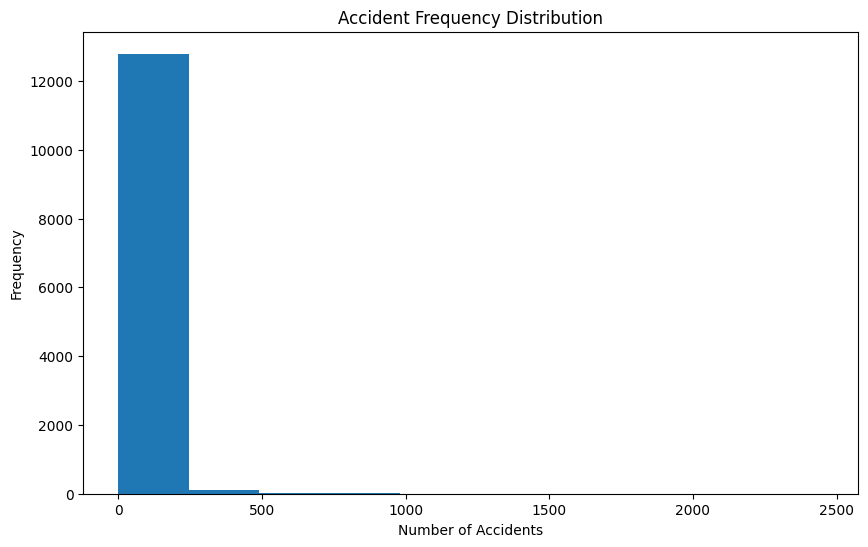

In [72]:
# Count the number of accidents for each mine
accident_counts = accidents_per_mine.iloc[:, 1:].count(axis=1)

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(accident_counts, bins=10)  # Adjust the number of bins as needed

# Set labels and title
plt.xlabel('Number of Accidents')
plt.ylabel('Frequency')
plt.title('Accident Frequency Distribution')

# Show the plot
plt.show()

In [83]:
# Violation Occur Date is not always the same as Violation Issue Date - 
# Have to decide which one to use 
violations[violations['VIOLATION_ISSUE_DT'] != violations['VIOLATION_OCCUR_DT']][['VIOLATION_ISSUE_DT', 'VIOLATION_OCCUR_DT']]

,VIOLATION_ISSUE_DT,VIOLATION_OCCUR_DT
651127,03/24/2007,01/01/2003
15818,07/25/2005,01/01/2004
2751044,01/31/2005,01/01/2005
2343495,02/01/2006,01/01/2006
272994,02/01/2006,01/01/2006
...,...,...
1435444,05/02/2023,12/31/2022
1521989,03/08/2023,12/31/2022
1520310,03/09/2023,12/31/2022
1527594,03/22/2023,12/31/2022


In [82]:
# Sort Values by Violation Date
violations = violations.sort_values(by='VIOLATION_OCCUR_DT')

violations_per_mine = violations[['MINE_ID', 'VIOLATION_OCCUR_DT']]

# Create a new column 'VIOLATION' with unique violation numbers
violations_per_mine.loc[:, 'VIOLATION'] = 'VIOLATION_' + (violations_per_mine.groupby('MINE_ID').cumcount() + 1).astype(str)

# Pivot the DataFrame to reshape it with 'MINE_ID' as the index and 'VIOLATION' as the columns
violations_per_mine = violations_per_mine.pivot(index='MINE_ID', columns='VIOLATION', values='VIOLATION_OCCUR_DT')

# Rename the columns with the desired format
violations_per_mine.columns = ['VIOLATION_' + str(i) for i in range(1, len(violations_per_mine.columns) + 1)]

# Reset the index of the DataFrame
violations_per_mine = violations_per_mine.reset_index()

## Merge the Violations and the Accident dates into one dataframe

In [ ]:
merged_df = pd.merge(violations_per_mine, accidents_per_mine, on = 'MINE_ID')

In [ ]:
# Change date columns to date date types
date_columns = [col for col in merged_df.columns if col != 'MINE_ID']
merged_df[date_columns] = merged_df[date_columns].apply(pd.to_datetime)

# Verify the result
print(merged_df.dtypes)

MINE_ID                   int64
VIOLATION_1      datetime64[ns]
VIOLATION_2      datetime64[ns]
VIOLATION_3      datetime64[ns]
VIOLATION_4      datetime64[ns]
                      ...      
ACCIDENT_2450    datetime64[ns]
ACCIDENT_2451    datetime64[ns]
ACCIDENT_2452    datetime64[ns]
ACCIDENT_2453    datetime64[ns]
ACCIDENT_2454    datetime64[ns]
Length: 21064, dtype: object


filter it down for now for simplicity and to run faster 

In [ ]:
# Calculate the percentage of NA values for each column
na_percentages = merged_df.iloc[:, 1:].isnull().mean()

# # Get the columns with less than or equal to 50% NA values
columns_to_keep = na_percentages[na_percentages <= 0.30].index.tolist()

# # Select the columns to keep in merged_df
merged_df= merged_df[['MINE_ID'] + columns_to_keep]

In [ ]:
#merged_df = merged_df[['MINE_ID', 'VIOLATION_1', 'ACCIDENT_1']]

In [ ]:
# Find the last violation column
last_violation_col = merged_df.filter(regex='VIOLATION').columns[-1]
num_violation_cols = int(last_violation_col.split('_')[1])
print('There are', num_violation_cols, 'violation columns')

# Find the last accident column
last_accident_col = merged_df.filter(regex='ACCIDENT').columns[-1]
num_accident_cols = int(last_accident_col.split('_')[1])
print('There are', num_accident_cols, 'accident columns')

There are 17499 violation columns
There are 1112 accident columns


In [ ]:
merged_df.filter(regex = 'VIOLATION').columns

Index(['VIOLATION_1', 'VIOLATION_2', 'VIOLATION_1113', 'VIOLATION_2224',
       'VIOLATION_3335', 'VIOLATION_4446', 'VIOLATION_5557', 'VIOLATION_6668',
       'VIOLATION_7779', 'VIOLATION_8890', 'VIOLATION_9611', 'VIOLATION_9722',
       'VIOLATION_9723', 'VIOLATION_9834', 'VIOLATION_9945', 'VIOLATION_10056',
       'VIOLATION_10167', 'VIOLATION_10278', 'VIOLATION_10389',
       'VIOLATION_10500', 'VIOLATION_10611', 'VIOLATION_10722',
       'VIOLATION_10833', 'VIOLATION_10834', 'VIOLATION_10945',
       'VIOLATION_11056', 'VIOLATION_11167', 'VIOLATION_11278',
       'VIOLATION_11944', 'VIOLATION_13055', 'VIOLATION_14166',
       'VIOLATION_15277', 'VIOLATION_16388', 'VIOLATION_17499'],
      dtype='object')

In [ ]:
#merged_df = merged_df.drop(columns = ['VIOLATION_1_30'])

Create columns for each VIOLATION column that shows 30 days out from that violation 

In [ ]:
for i in range(1, num_violation_cols+1):  # Adjust the range based on the number of VIOLATION_i columns
    
    ## 30 days
    violation_col = f'VIOLATION_{i}'
    new_col = f'VIOLATION_{i}_30'

    if violation_col in merged_df.columns: 
        # Extract the VIOLATION_i column
        violation_dates = merged_df[violation_col]

        # Add 30 days to each date in the VIOLATION_i column
        violation_dates_30 = violation_dates + timedelta(days=30)

        # Add the new column to the DataFrame
        merged_df.insert(merged_df.columns.get_loc(violation_col) + 1, new_col, violation_dates_30)

    ## 60 days 
    violation_col = f'VIOLATION_{i}'
    new_col = f'VIOLATION_{i}_60'

    if violation_col in merged_df.columns: 
        # Extract the VIOLATION_i column
        violation_dates = merged_df[violation_col]

        # Add 60 days to each date in the VIOLATION_i column
        violation_dates_60 = violation_dates + timedelta(days=60)

        # Add the new column to the DataFrame
        merged_df.insert(merged_df.columns.get_loc(violation_col) + 1, new_col, violation_dates_60)

     
    ## 90 days
    violation_col = f'VIOLATION_{i}'
    new_col = f'VIOLATION_{i}_90'

    if violation_col in merged_df.columns:
        # Extract the VIOLATION_i column
        violation_dates = merged_df[violation_col]

        # Add 30 days to each date in the VIOLATION_i column
        violation_dates_90 = violation_dates + timedelta(days=90)

        # Add the new column to the DataFrame
        merged_df.insert(merged_df.columns.get_loc(violation_col) + 1, new_col, violation_dates_90)

In [ ]:
merged_df

,MINE_ID,VIOLATION_1,VIOLATION_1_90,VIOLATION_1_60,VIOLATION_1_30,VIOLATION_2,VIOLATION_2_90,VIOLATION_2_60,VIOLATION_2_30,VIOLATION_1113,...,VIOLATION_16388,VIOLATION_16388_90,VIOLATION_16388_60,VIOLATION_16388_30,VIOLATION_17499,VIOLATION_17499_90,VIOLATION_17499_60,VIOLATION_17499_30,ACCIDENT_1,ACCIDENT_1112
0,100003,2002-01-02,2002-04-02,2002-03-03,2002-02-01,2000-01-04,2000-04-03,2000-03-04,2000-02-03,2000-01-04,...,2013-01-03,2013-04-03,2013-03-04,2013-02-02,2000-01-04,2000-04-03,2000-03-04,2000-02-03,2007-01-08,2005-01-14
1,100004,2013-01-02,2013-04-02,2013-03-03,2013-02-01,2013-01-03,2013-04-03,2013-03-04,2013-02-02,2013-01-03,...,2013-01-03,2013-04-03,2013-03-04,2013-02-02,2013-01-03,2013-04-03,2013-03-04,2013-02-02,2008-01-07,2010-01-09
2,100006,2016-01-27,2016-04-26,2016-03-27,2016-02-26,2008-04-14,2008-07-13,2008-06-13,2008-05-14,2015-04-14,...,2010-03-09,2010-06-07,2010-05-08,2010-04-08,2006-04-11,2006-07-10,2006-06-10,2006-05-11,2000-01-13,2015-02-08
3,100008,2019-01-10,2019-04-10,2019-03-11,2019-02-09,2016-02-02,2016-05-02,2016-04-02,2016-03-03,2016-02-02,...,2013-01-22,2013-04-22,2013-03-23,2013-02-21,2013-01-30,2013-04-30,2013-03-31,2013-03-01,2015-01-06,2015-01-07
4,100009,2007-01-03,2007-04-03,2007-03-04,2007-02-02,2011-01-13,2011-04-13,2011-03-14,2011-02-12,2013-01-16,...,2013-01-10,2013-04-10,2013-03-11,2013-02-09,2013-01-10,2013-04-10,2013-03-11,2013-02-09,2023-02-21,2007-03-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12807,5400493,2023-01-12,2023-04-12,2023-03-13,2023-02-11,2023-02-10,2023-05-11,2023-04-11,2023-03-12,2016-02-18,...,2020-01-22,2020-04-21,2020-03-22,2020-02-21,2020-01-22,2020-04-21,2020-03-22,2020-02-21,2022-09-14,NaT
12808,5400500,2022-02-07,2022-05-08,2022-04-08,2022-03-09,2019-06-18,2019-09-16,2019-08-17,2019-07-18,2019-06-18,...,2019-06-18,2019-09-16,2019-08-17,2019-07-18,2019-06-18,2019-09-16,2019-08-17,2019-07-18,2022-02-02,NaT
12809,5500002,2000-01-13,2000-04-12,2000-03-13,2000-02-12,2012-01-30,2012-04-29,2012-03-30,2012-02-29,2012-01-30,...,2016-01-27,2016-04-26,2016-03-27,2016-02-26,2016-01-27,2016-04-26,2016-03-27,2016-02-26,2019-01-03,2016-01-13
12810,5500005,2000-01-11,2000-04-10,2000-03-11,2000-02-10,2000-10-19,2001-01-17,2000-12-18,2000-11-18,NaT,...,2000-10-17,2001-01-15,2000-12-16,2000-11-16,2000-10-18,2001-01-16,2000-12-17,2000-11-17,2001-01-09,2001-01-22


Add column to count how many accidents have occured in the 30 days since that accident

In [ ]:
# Extract the violation columns into a separate DataFrame
violation_df = merged_df.filter(regex='^VIOLATION')

# Select the accident columns
accident_df = merged_df.filter(regex='^ACCIDENT')

# Initialize an empty DataFrame to store the count of accidents
accidents_after_violation_df = pd.DataFrame(index=merged_df.index)

# Iterate over each violation column
for i in range(1, num_violation_cols + 1):

    violation_col = f'VIOLATION_{i}'
    violation_30_col = f'VIOLATION_{i}_30'
    
    if violation_col and violation_30_col in merged_df.columns: 

        # Create a mask to filter the accidents columns within the range of violation dates
        mask = (accident_df >= violation_df[violation_col].values[:, np.newaxis]) & (accident_df <= violation_df[violation_30_col].values[:, np.newaxis])

        # Count the number of accidents within the range for each row
        count_accidents = mask.sum(axis=1)

        # Add the count as a new column to the accidents_after_violation_df DataFrame
        column_name = f'ACCIDENTS_AFTER_VIOLATION_{i}'
        accidents_after_violation_df[column_name] = count_accidents

# Concatenate the accidents_after_violation_df DataFrame with the merged_df DataFrame
merged_df = pd.concat([merged_df, accidents_after_violation_df], axis=1)

In [ ]:
merged_df.filter(regex = 'ACCIDENTS_AFTER_VIOLATION_1').columns

Index(['ACCIDENTS_AFTER_VIOLATION_1', 'ACCIDENTS_AFTER_VIOLATION_1113',
       'ACCIDENTS_AFTER_VIOLATION_10056', 'ACCIDENTS_AFTER_VIOLATION_10167',
       'ACCIDENTS_AFTER_VIOLATION_10278', 'ACCIDENTS_AFTER_VIOLATION_10389',
       'ACCIDENTS_AFTER_VIOLATION_10500', 'ACCIDENTS_AFTER_VIOLATION_10611',
       'ACCIDENTS_AFTER_VIOLATION_10722', 'ACCIDENTS_AFTER_VIOLATION_10833',
       'ACCIDENTS_AFTER_VIOLATION_10834', 'ACCIDENTS_AFTER_VIOLATION_10945',
       'ACCIDENTS_AFTER_VIOLATION_11056', 'ACCIDENTS_AFTER_VIOLATION_11167',
       'ACCIDENTS_AFTER_VIOLATION_11278', 'ACCIDENTS_AFTER_VIOLATION_11944',
       'ACCIDENTS_AFTER_VIOLATION_13055', 'ACCIDENTS_AFTER_VIOLATION_14166',
       'ACCIDENTS_AFTER_VIOLATION_15277', 'ACCIDENTS_AFTER_VIOLATION_16388',
       'ACCIDENTS_AFTER_VIOLATION_17499'],
      dtype='object')

Merge the Violations and the Accident dates into one dataframe

In [89]:
merged_df = pd.merge(violations_per_mine, accidents_per_mine, on = 'MINE_ID')

In [119]:
# Calculate the percentage of NA values for each column
na_percentages = merged_df.iloc[:, 1:].isnull().mean()

# # Get the columns with less than or equal to 50% NA values
columns_to_keep = na_percentages[na_percentages <= 0.5].index.tolist()

# # Select the columns to keep in merged_df
merged_df_filtered = merged_df[['MINE_ID'] + columns_to_keep]


In [123]:
merged_df = merged_df[['MINE_ID', 'VIOLATION_1', 'ACCIDENT_1']]

In [128]:
# Convert 'ACCIDENT_DT' column in accidents DataFrame to datetime format
accidents['ACCIDENT_DT'] = pd.to_datetime(accidents['ACCIDENT_DT'], format='%m/%d/%Y')

# Define time intervals
time_intervals = [30, 60, 90]

# Create a new DataFrame to store the results
result_df = pd.DataFrame({'MINE_ID': merged_df['MINE_ID']})

# Iterate over each violation column
for col in merged_df.columns[1:]:
    # Extract the violation dates for the column and drop NA values
    violation_dates = merged_df[col].dropna()
    
    # Create a DataFrame to store the results for the current violation column
    violation_result_df = pd.DataFrame({'MINE_ID': merged_df['MINE_ID'], col: violation_dates})
    
    # Calculate date ranges for each time interval
    start_dates = [pd.to_datetime(violation_dates, format='%m/%d/%Y') + pd.DateOffset(days=interval) for interval in time_intervals]
    end_dates = [start_date + pd.DateOffset(days=1) for start_date in start_dates]
    
    # Check if an accident occurred within each time interval
    accidents_within_intervals = pd.merge(violation_result_df[['MINE_ID']], accidents, on='MINE_ID')
    accidents_within_intervals = accidents_within_intervals[(accidents_within_intervals['ACCIDENT_DT'].values[:, None] >= start_dates[0].values) & (accidents_within_intervals['ACCIDENT_DT'].values[:, None] < end_dates[0].values)]
    
    # Reshape the result to a 2D array
    result = np.zeros((len(violation_result_df), len(time_intervals)))
    
    # Determine which intervals have accidents
    for i, interval in enumerate(time_intervals):
        has_accident = np.isin(violation_result_df['MINE_ID'].values, accidents_within_intervals.loc[(accidents_within_intervals['ACCIDENT_DT'] >= start_dates[i].iloc[:, 0]) & (accidents_within_intervals['ACCIDENT_DT'] < end_dates[i].iloc[:, 0]), 'MINE_ID'].values)
        result[:, i] = has_accident.astype(int)
    
    # Add binary columns indicating if an accident occurred
    violation_result_df[[f'{col}_{interval}' for interval in time_intervals]] = result
    
    # Merge the results for the current violation column into the main result DataFrame
    result_df = pd.merge(result_df, violation_result_df, on='MINE_ID')

# Sort the result DataFrame by MINE_ID
result_df = result_df.sort_values(by='MINE_ID')

# Reset the index of the DataFrame
result_df = result_df.reset_index(drop=True)

IndexingError: Too many indexers

# Data Partitioning

# Modeling

# Results